# Importing necessary headers

In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import pickle

# Camera Calibration
# 1. Compute camera matrix and distortion coefficients to calibrate camera

In [2]:
# function to calibrate the camera
def calibrate_camera(gray, obj_points, img_points):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

# function that returns an image after distortion correction
def correct_for_distortion(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# function to warp an image
#def warped_image(img, nx, ny, mtx, dist):

In [3]:
# specifying number of corners in an image
nx = 9 # number of corners in the x direction
ny = 6 # number of corners in the y direction

# read the test image using cv2.read() method
img = cv2.imread("camera_cal/calibration2.jpg") 

# reading in all the images and iterate through them then use glob
# images = glob.glob("camera_cal/calibration*.jpg")

# prepare object points and image points for camera calibration
obj_points = [] # these are the 3D points in the real world
img_points = [] # these are the 2D points in the image plane/world

obj_p = np.zeros((6*9,3),np.float32)
obj_p[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# convert image to gray scale using cv2.cvtColor() method
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# locate the chessboard corners using cv2.findChessboardCorners()
ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)

print(ret)
# if corners are found then ret would be True, then add the points to img_points
if ret==True:
    img_points.append(corners)
    obj_points.append(obj_p)
    # draw the corners and display
    #img_cor = cv2.drawChessboardCorners(img,(9,6),corners,ret)
    #plt.imshow(img_cor)    

# Now everything is ready and we can use the cv2.calibrateCamera() function to find the distortion coefficients
ret, mtx, dist, rvecs, tvecs = calibrate_camera(gray, obj_points, img_points)

# correct for distortion
undist = correct_for_distortion(img, mtx, dist) # using distortion coeff to undistort the image
gray_undist = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

True


# Visualizing the camera calibration result

In [4]:
# function to plot 2 images for comparison
def subplot_121_122(img1,title1,img2,title2): 
    %matplotlib inline
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(121)
    ax.imshow(img1,cmap="gray")
    ax.set_title(title1)
    ax2 = f.add_subplot(122)
    ax2.imshow(img2,cmap="gray")
    ax2.set_title(title2)

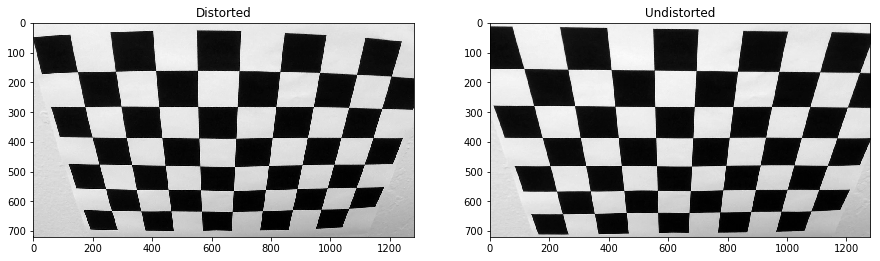

In [5]:
subplot_121_122(gray,"Distorted",gray_undist,"Undistorted")
#plt.savefig("output_images/Camera_Calibration.jpg",bbox="tight")

In [6]:
with open('Timestamp_41.pkl','rb') as f:
    false = pickle.load(f)

In [7]:
undistorted_test_image1 = correct_for_distortion(false[0], mtx, dist)
undistorted_test_image2 = correct_for_distortion(false[1], mtx, dist)
undistorted_test_image3 = correct_for_distortion(false[2], mtx, dist)

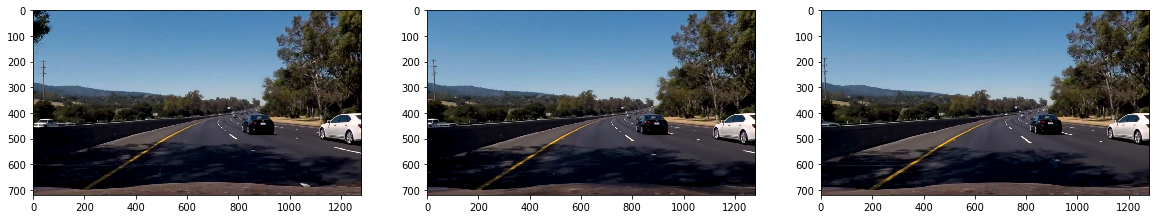

In [8]:
plt.figure(figsize=(20,15))
plt.subplot(131)
plt.imshow(undistorted_test_image1)
plt.subplot(132)
plt.imshow(undistorted_test_image2)
plt.subplot(133)
plt.imshow(undistorted_test_image3)

# Color transform and gradients
# 2. Use color transforms and gradients to create a thresholded binary image

In [44]:
def abs_sobel_thresh(i, orient='x', sobel_kernel=3, abs_thresh=(0,255)):
    # convert to a grayscale image
    gray_i = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)
    # based on orient value compute sobelx or sobely followed by absolute value
    if orient=='x':
        sobelx = cv2.Sobel(gray_i,cv2.CV_64F,1,0,ksize=sobel_kernel)
        abs_sobel = np.absolute(sobelx)
    else:
        sobely = cv2.Sobel(gray_i,cv2.CV_64F,0,1,ksize=sobel_kernel)
        abs_sobel = np.absolute(sobely)
    # convert the absolute value to 8-bit
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # define a binary output
    binary_output = np.zeros_like(scaled_sobel)
    # applying the threshold
    binary_output[(scaled_sobel>=abs_thresh[0]) & (scaled_sobel<=abs_thresh[1])]=1
    # return binary output
    return binary_output
        
def mag_thresh(i, sobel_kernel = 3, magnitude_thresh=(0,255)):
    # convert to a grayscale image
    gray_i = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)
    # compute sobelx and sobely
    sobelx = cv2.Sobel(gray_i,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_i,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # compute the magnitude
    mag = np.sqrt(sobely*sobely + sobelx*sobelx)
    # scale to 8-bit and convert to type uint8
    scale_factor = np.max(mag)/255
    scaled_mag = (mag/scale_factor).astype(np.uint8)
    # define a binary output
    binary_output = np.zeros_like(gray_i)
    # apply the threshold
    binary_output[(scaled_mag>=magnitude_thresh[0]) & (scaled_mag<=magnitude_thresh[1])]=1
    # return the binary_output
    return binary_output

def direc_thresh(i, sobel_kernel = 3, dir_thresh=(0,np.pi/2)):
    # convert to a grayscale image
    gray_i = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)
    # compute sobelx and sobely
    sobelx = cv2.Sobel(gray_i,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_i,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # compute the direction of the gradient
    abs_grad_dir = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    # define a binary output
    binary_output = np.zeros_like(gray_i)
    # applying the threshold
    binary_output[(abs_grad_dir>=dir_thresh[0]) & (abs_grad_dir<=dir_thresh[1])]=1
    # return the binary output
    return binary_output

def S_thresh(i, s_thresh=(0,255)): 
    # convert image from RGB to HLS channel
    hls = cv2.cvtColor(i, cv2.COLOR_RGB2HLS)
    # separatre the S channel
    S = hls[:,:,2]
    # define a binary output
    binary_output = np.zeros_like(S)
    # applying the threshold
    #print(s_thresh)
    binary_output[(S > s_thresh[0]) & (S <= s_thresh[1])]=1
    # return the binary output
    return binary_output

def B_thresh(i, b_thresh=(155,255)): # LAB colorspace
    lab = cv2.cvtColor(i, cv2.COLOR_RGB2Lab)
    B = lab[:,:,2]
    binary_output = np.zeros_like(B)
    binary_output[(B > b_thresh[0]) & (B <= b_thresh[1])]=1
    return binary_output

def LUV_L_thresh(i, l_thresh=(190,255)): # LAB colorspace
    lab = cv2.cvtColor(i, cv2.COLOR_RGB2LUV)
    L = lab[:,:,0]
    binary_output = np.zeros_like(L)
    binary_output[(L > l_thresh[0]) & (L <= l_thresh[1])]=1
    return binary_output

#def apply_thresholds(i):
#    s_channel = cv2.cvtColor(i, cv2.COLOR_BGR2HLS)[:,:,2]
#    l_channel = cv2.cvtColor(i, cv2.COLOR_BGR2LUV)[:,:,0]
#    b_channel = cv2.cvtColor(i, cv2.COLOR_BGR2Lab)[:,:,2]   
#    u_channel = cv2.cvtColor(i, cv2.COLOR_BGR2YUV)[:,:,1]

    # Threshold color channel
#    s_thresh_min = 155
#    s_thresh_max = 255
#    s_binary = np.zeros_like(s_channel)
#    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
#    b_thresh_min = 150
#    b_thresh_max = 200
#    b_binary = np.zeros_like(b_channel)
#    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
#    l_thresh_min = 225
#    l_thresh_max = 255
#    l_binary = np.zeros_like(l_channel)
#    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
#    u_thresh_min = 140
#    u_thresh_max = 180
#    u_binary = np.zeros_like(u_channel)
#    u_binary[(u_channel >= u_thresh_min) & (u_channel <= u_thresh_max)]

#    combined_binary = np.zeros_like(s_binary)
#    combined_binary[(l_binary == 1) | (b_binary == 1) | (u_binary==1)] = 1 #| (s_binary==1)
#    return combined_binary

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def comibned_threshold(abs_sobel_x, abs_sobel_y, m_thresh, d_thresh, hls_thresh, lab_thresh, luv_thresh):
    combine = np.zeros_like(m_thresh)
    combine[((abs_sobel_x==1)&(abs_sobel_y==1)) | ((m_thresh==1)&(d_thresh==1))]=1
    COMBINE_with_HLS_THRESH = np.zeros_like(combine)
    COMBINE_with_HLS_THRESH[(combine==1) | (lab_thresh==1) | (luv_thresh==1)]=1
    # mask the region that must conatin the lane lines
    vertices = np.array([[(400,400), #0,400
                      (800,400),   #1280,400
                      (1280,720), #1280, 720
                      (0,720)]], dtype=np.int32) 
    masked_image = region_of_interest(COMBINE_with_HLS_THRESH, vertices) # masked image obtained
    return masked_image#COMBINE_with_HLS_THRESH#

def get_thresholded_image(i):
    # choode a kernel size
    ksize = 3 # large odd number for smoother gradient measurements
    # obtain sobel x thresholded image
    abs_thresh_x = abs_sobel_thresh(i,orient='x',sobel_kernel=ksize, abs_thresh=(20,100))
    # obtain sobel y thresholded image
    abs_thresh_y = abs_sobel_thresh(i,orient='y',sobel_kernel=ksize, abs_thresh=(20,100))
    # obtain magnitude thresholded image
    magnitude_t = mag_thresh(i,sobel_kernel=ksize,magnitude_thresh=(20,100))
    # obtain directional thresholded image
    direction_t = direc_thresh(i, sobel_kernel=15,dir_thresh=(0.7,1.4))#(0,np.pi/2))
    # obtain S channel thresholded image after color trasnform to HLS type
    hls_s_thresh = S_thresh(i,s_thresh=(155,255))
    lab_b_thresh = B_thresh(i,b_thresh=(150,255))
    luv_l_thresh = LUV_L_thresh(i,l_thresh=(225,255))
    combined = comibned_threshold(abs_thresh_x, abs_thresh_y, magnitude_t, direction_t, hls_s_thresh, lab_b_thresh, \
                                  luv_l_thresh)
    return abs_thresh_x, abs_thresh_y, magnitude_t, direction_t, hls_s_thresh, lab_b_thresh, luv_l_thresh, combined

In [45]:
# function call to obtain all the thresholded images in one line
THRESH_ABS_X1, THRESH_ABS_Y1, THRESH_MAG1,\
THRESH_DIR1, THRESH_HLS_S1, THRESH_LAB_B1, THRESH_LUV_L1, COMBINED1 = get_thresholded_image(undistorted_test_image1)

THRESH_ABS_X2, THRESH_ABS_Y2, THRESH_MAG2,\
THRESH_DIR2, THRESH_HLS_S2, THRESH_LAB_B2, THRESH_LUV_L2, COMBINED2 = get_thresholded_image(undistorted_test_image2)

THRESH_ABS_X3, THRESH_ABS_Y3, THRESH_MAG3,\
THRESH_DIR3, THRESH_HLS_S3, THRESH_LAB_B3, THRESH_LUV_L3, COMBINED3 = get_thresholded_image(undistorted_test_image3)

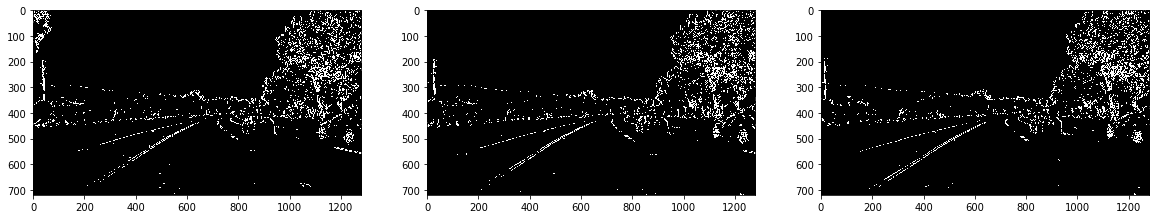

In [46]:
plt.figure(figsize=(20,15)) ### SOBEL X
plt.subplot(131)
plt.imshow(THRESH_ABS_X1, cmap ='gray')
plt.subplot(132)
plt.imshow(THRESH_ABS_X2, cmap = 'gray')
plt.subplot(133)
plt.imshow(THRESH_ABS_X3, cmap = 'gray')

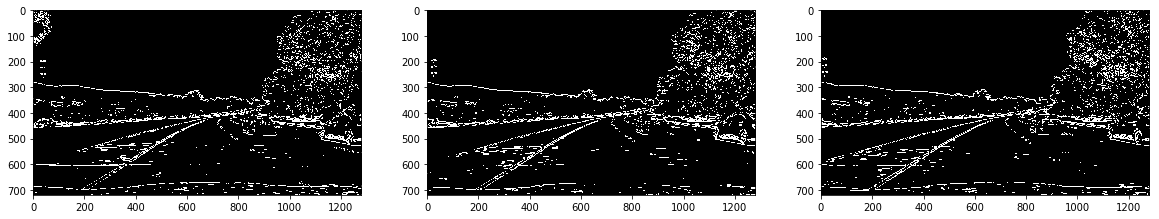

In [47]:
plt.figure(figsize=(20,15)) ### SOBEL X
plt.subplot(131)
plt.imshow(THRESH_ABS_Y1, cmap ='gray')
plt.subplot(132)
plt.imshow(THRESH_ABS_Y2, cmap = 'gray')
plt.subplot(133)
plt.imshow(THRESH_ABS_Y3, cmap = 'gray')

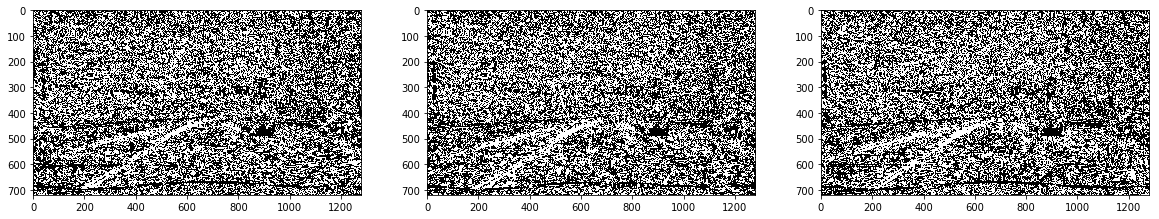

In [48]:
plt.figure(figsize=(20,15)) ### SOBEL X
plt.subplot(131)
plt.imshow(THRESH_DIR1, cmap ='gray')
plt.subplot(132)
plt.imshow(THRESH_DIR2, cmap = 'gray')
plt.subplot(133)
plt.imshow(THRESH_DIR3, cmap = 'gray')

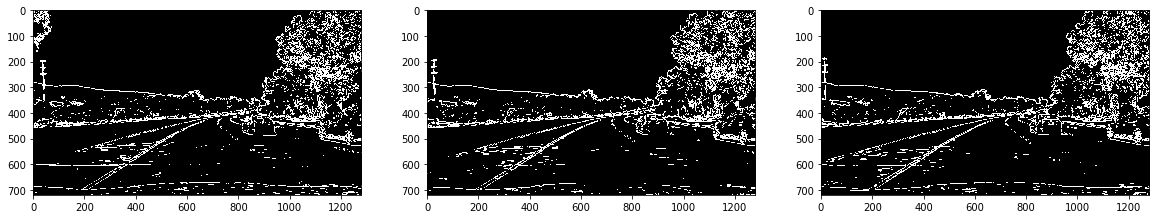

In [49]:
plt.figure(figsize=(20,15)) ### SOBEL X
plt.subplot(131)
plt.imshow(THRESH_MAG1, cmap ='gray')
plt.subplot(132)
plt.imshow(THRESH_MAG2, cmap = 'gray')
plt.subplot(133)
plt.imshow(THRESH_MAG3, cmap = 'gray')

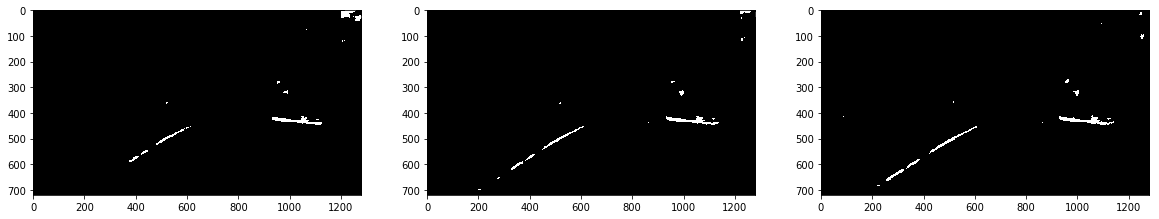

In [50]:
plt.figure(figsize=(20,15)) ### SOBEL X
plt.subplot(131)
plt.imshow(THRESH_LAB_B1, cmap ='gray')
plt.subplot(132)
plt.imshow(THRESH_LAB_B2, cmap = 'gray')
plt.subplot(133)
plt.imshow(THRESH_LAB_B3, cmap = 'gray')

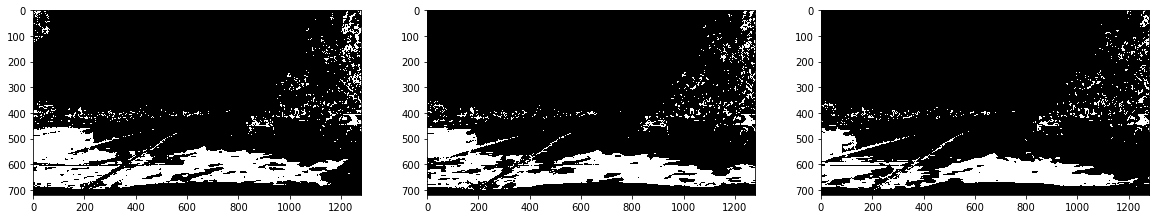

In [51]:
plt.figure(figsize=(20,15)) ### SOBEL X
plt.subplot(131)
plt.imshow(THRESH_HLS_S1, cmap ='gray')
plt.subplot(132)
plt.imshow(THRESH_HLS_S2, cmap = 'gray')
plt.subplot(133)
plt.imshow(THRESH_HLS_S3, cmap = 'gray')

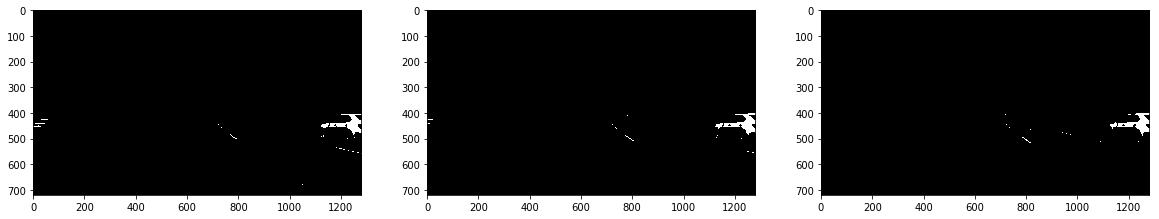

In [52]:
plt.figure(figsize=(20,15)) ### SOBEL X
plt.subplot(131)
plt.imshow(THRESH_LUV_L1, cmap ='gray')
plt.subplot(132)
plt.imshow(THRESH_LUV_L2, cmap = 'gray')
plt.subplot(133)
plt.imshow(THRESH_LUV_L3, cmap = 'gray')

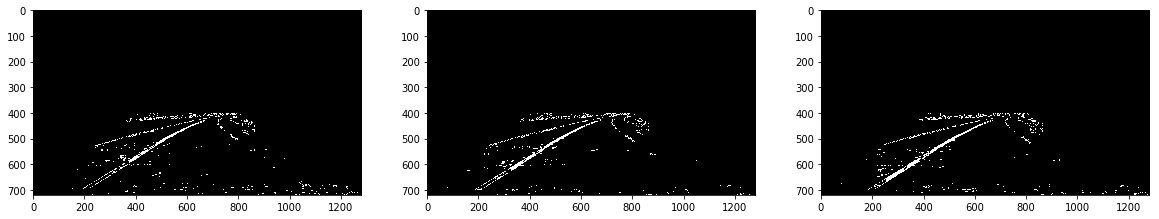

In [53]:
plt.figure(figsize=(20,15)) ### SOBEL X
plt.subplot(131)
plt.imshow(COMBINED1, cmap ='gray')
plt.subplot(132)
plt.imshow(COMBINED2, cmap = 'gray')
plt.subplot(133)
plt.imshow(COMBINED3, cmap = 'gray')

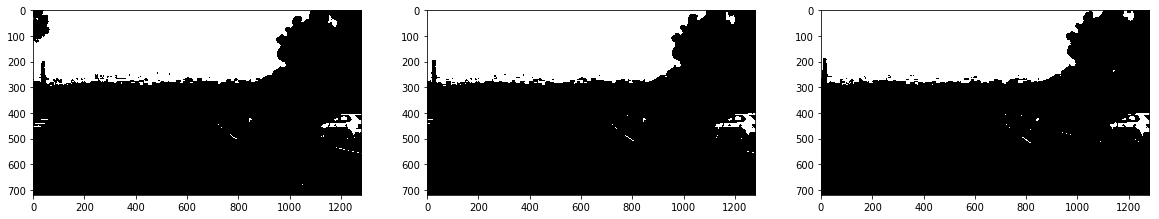

In [54]:
#plt.figure(figsize=(20,15)) ### SOBEL X
#plt.subplot(131)
#plt.imshow(apply_thresholds(undistorted_test_image1), cmap ='gray')
#plt.subplot(132)
#plt.imshow(apply_thresholds(undistorted_test_image2), cmap = 'gray')
#plt.subplot(133)
#plt.imshow(apply_thresholds(undistorted_test_image3), cmap = 'gray')

# So far, it is evident that just using a color threshold for the S channel after converting the image into HLS color space gives a good result for the binary image that can be used for further analysis.

# Next we do Perspective transform.

In [55]:
def perspective_transform(i):
    i_size = (i.shape[1],i.shape[0])
    #src = np.float32([[490, 482],[810, 482],
    #                  [1250, 720],[40, 720]])
    #dst = np.float32([[0, 0], [1280, 0], 
    #                 [1250, 720],[40, 720]])
    src = np.float32([[565,458], #550->525
                      [725,458], #760->785
                      [1040,680],
                      [260,680]])
    # Uncomment to see where the src points lie on the image
    #plt.imshow(i, cmap="gray")
    #plt.plot(550,470,'.')
    #plt.plot(760,470,'.')
    #plt.plot(1150,680,'.')
    #plt.plot(200,680,'.')
    dst = np.float32([[200,0],
                    [1000,0],
                    [1000,685],
                    [200,685]])
    # Uncomment to see where the source points lie on the image
    #plt.plot(200,50,'*')
    #plt.plot(1000,50,'*')
    #plt.plot(1000,680,'*')
    #plt.plot(200,680,'*')
    #src = np.float32(
    #                [[(i_size[0] / 2) - 55, i_size[1] / 2 + 100],
    #                [((i_size[0] / 6) - 10), i_size[1]],
    #                [(i_size[0] * 5 / 6) + 60, i_size[1]],
    #                [(i_size[0] / 2 + 55), i_size[1] / 2 + 100]])
    #dst = np.float32(
    #                [[(i_size[0] / 4), 0],
    #                [(i_size[0] / 4), i_size[1]],
    #                [(i_size[0] * 3 / 4), i_size[1]],
    #                [(i_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src,dst)
    M_inv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(i, M, i_size, flags=cv2.INTER_LINEAR)
    return M , M_inv,warped

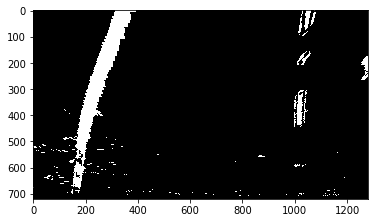

In [56]:
M, M_inv, w = perspective_transform(COMBINED3)#(THRESH_HLS_S)
plt.imshow(w, cmap="gray") # Show the warped image
#plt.savefig("output_images/Perspective_Transform_Combined_All_test_image_3.jpg",bbox="tight")

# Verifying Perspective Transform

In [57]:
test_image3 = false[0]
test_image_3_warped = cv2.warpPerspective(test_image3,M,(test_image3.shape[1],test_image3.shape[0])
                                                        ,flags=cv2.INTER_LINEAR)
subplot_121_122(test_image3,"Original Image",test_image_3_warped,"Perspective Transform")
#plt.savefig("output_images/Verifying_Perspective_Transform.jpg",bbox="tight")

IndexError: list index out of range

# Histogram: Finding the base location of the lane lines in the image

In [ ]:
def hist(i):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    i_shape = i.shape
    bottom_half = i[i_shape[0]//2:,:] # sliced image into half (slicing operator)
    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half,axis=0)
    # return histogram
    return histogram

# Sliding windows: To find the pixels that form the lane lines

In [ ]:
# finding lane line pixels
def find_lane_line_pixels(i):    
    h = hist(i)
    out_img = np.dstack((i,i,i))*255
    midpoint = np.int(h.shape[0]//2)
    leftx_base = np.argmax(h[:midpoint])
    rightx_base = np.argmax(h[midpoint:]) + midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(i.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = i.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # empty list to store the data of previous windows in case there are no good pixels in the window
    prev_good_left_inds = []
    prev_good_right_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries y coordinate
        win_y_low = i.shape[0] - (window+1)*window_height # the upper horizontal line of the window
        win_y_high = i.shape[0] - (window)*window_height # the lower horizontal line of the window 
        # Identify window boundaries x coordinate
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this    
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)    
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        #print(window,len(good_right_inds))
        # if there are no good pixels in the window, use the previous ones.
        if(len(good_left_inds)==0):
            good_left_inds = prev_good_left_inds
        if(len(good_right_inds)==0):
            good_right_inds = prev_good_right_inds
            
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        #np.append(left_lane_inds,good_left_inds)
        #np.append(right_lane_inds,good_right_inds)
        #print(left_lane_inds)
        # If you found > minpix pixels, recenter next window ###
        # (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        prev_good_left_inds = good_left_inds
        prev_good_right_inds = good_right_inds
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
    # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img


In [ ]:
leftx, lefty, rightx, righty, out_img = find_lane_line_pixels(w)

In [ ]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fit, right_fit, left_fitx, right_fitx, ploty

In [ ]:
left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(w.shape,leftx,lefty,rightx,righty) # fitting a polynomial through the pixels
## setting colors for visualization
out_img[lefty, leftx] = [255,0,0] # left lane pixels denoted with RED color
out_img[righty, rightx] = [0,0,255] # right lane pixels denoted with BLUE color
subplot_121_122(w,"Warped Image",out_img,"Polyfitted Lane Lines")
plt.plot(left_fitx,ploty,color="yellow")
plt.plot(right_fitx,ploty,color="yellow")
#plt.savefig("output_images/Polyfitted_Lane_Lines_test_image_3.jpg",bbox="tight")

In [ ]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) +
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    A , B,left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

    return result, A, B

In [ ]:
result, A, B = search_around_poly(w,left_fit,right_fit)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
#plt.savefig("output_images/Lane_Lines_Window_test_image_3.jpg",bbox="tight")

# Radius of Curvature: Pixel Radius

In [ ]:
def measure_curvature_pixels(left_fit, right_fit,w):
    y_eval = w.shape[0] # y_eval is the y value at the bottom of the image
    left_curverad = (1 + (2*left_fit[0]*y_eval+left_fit[1])**2)**(3/2)/(2*left_fit[0]) # left line calculation
    right_curverad = (1 + (2*right_fit[0]*y_eval+right_fit[1])**2)**(3/2)/(2*right_fit[0]) # right line calculation
    return left_curverad, right_curverad

In [ ]:
lr_pix, rr_pix = measure_curvature_pixels(left_fit, right_fit, w)
print(lr_pix,rr_pix)

# Radius of Curvature: Real Radius

In [ ]:
def measure_curvature_real(leftx, rightx, lefty, righty, w):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = w.shape[0]#np.max(ploty)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix,2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix,2)
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) \
    / np.absolute(2*left_fit_cr[0])  # left line 
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) \
    / np.absolute(2*right_fit_cr[0])# right line 
    
    return left_curverad, right_curverad

In [ ]:
lr_real, rr_real = measure_curvature_real(leftx, rightx, lefty, righty, w)
print(lr_real,rr_real)

# Determine the vehicle position

In [ ]:
def vehicle_position(w, left_fit,right_fit):
    y_bottom = w.shape[0]    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension    
    left_bottom = left_fit[0]*y_bottom*y_bottom + left_fit[1]*y_bottom + left_fit[2]
    right_bottom = right_fit[0]*y_bottom*y_bottom + right_fit[1]*y_bottom + right_fit[2]
    lane_center_bottom_in_pixels = np.average([left_bottom,right_bottom])
    lane_center_bottom_in_meters = ((w.shape[1]/2) - lane_center_bottom_in_pixels)*xm_per_pix
    car_position = dict()
    if(lane_center_bottom_in_meters<0):
        car_position['left'] = lane_center_bottom_in_meters
    elif (lane_center_bottom_in_meters==0):
        car_position['center'] = lane_center_bottom_in_meters
    else:
        car_position['right'] = lane_center_bottom_in_meters
    return lane_center_bottom_in_meters

In [58]:
lane_center_in_meters = vehicle_position(w,left_fit,right_fit)

# Displaying back on the image

In [59]:
def display_on_image(w,left_fit,right_fit,M_inv,lr_real,rr_real,lane_center_bottom_real, undist):
    y_values = np.linspace(0, w.shape[0]-1, w.shape[0] )
    left_line = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_line = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    w_zero = np.zeros_like(w).astype(np.uint8)
    color_w = np.dstack((w_zero, w_zero, w_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line, y_values]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line, y_values])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_w, np.int_([pts]), (128,0, 0)) # dark red rgb values (128,0,0)
    #plt.imshow(color_w)
    #Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    warp_to_original = cv2.warpPerspective(color_w, M_inv, (undist.shape[1], undist.shape[0])) 
    #plt.imshow(newwarp)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, warp_to_original, 0.3, 0)
    return result

In [60]:
asd = display_on_image(w,left_fit,right_fit,M_inv,lr_real,rr_real,lane_center_in_meters,false[2])#str8_lines_2)
plt.figure(figsize=(15,15))
plt.imshow(asd)

IndexError: list index out of range

In [61]:
def is_it_really_a_lane(left_fit, right_fit):
    if len(left_fit) ==0 or len(right_fit) == 0: # if both or any of the left and the right lanes are detected.
        found = False
    else:
        #ploty = np.linspace(0, 20, num=10 )      
        #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        #dist_bw_lines = np.mean(right_fitx - left_fitx) # distance between lines detected
        #if dist_bw_lines >= 150 and dist_bw_lines <=430: 
        #    found = True                                # appropriate distance between the detected lines
        #else:
        #    found = False                               # not appropriate distance between the detected lines
        
        slope_l = 2*left_fit[0]*360+left_fit[1]       # check slope at the middle of the lane to check if parallel
        slope_r = 2*right_fit[0]*360+right_fit[1]
        difference_in_slope =  np.abs(slope_l-slope_r)
        
        if difference_in_slope <= 0.55 and difference_in_slope >= 0.0: # if the difference in slope is less than 0.1, the lines are more or less parallel
            found = True
        else:
            found = False
    return found

In [62]:
class Line():
    def __init__(self):
        self.detected = False    # was the line detected in the last iteration?
        self.recent_xfitted = [] # x values of the last n fits of the line
        self.bestx = None        # average x values of the fitted line over the last n iterations
        self.best_fit = None     # polynomial coefficients averaged over the last n iterations
        self.current_fit = [np.array([False])]  # polynomial coefficients for the most recent fit
        self.radius_of_curvature = None  # radius of curvature of the line in some units
        self.line_base_pos = None  # distance in meters of vehicle center from the line
        self.diffs = np.array([0,0,0], dtype='float')  # difference in fit coefficients between last and new fits
        #self.allx = None         # x values for detected line pixels
        #self.ally = None         # y values for detected line pixels
        self.count = 0
        self.reset_count = 0
        self.prev_left = None
        self.prev_right = None
        self.left_fit = None
        self.right_fit = None
        self.left_lane = []
        self.right_lane = []
    def add_lane(self, left, right):
        self.left_lane.append(left)
        self.right_lane.append(right)

l = Line()

# Pipeline for a single image

In [63]:
# some reference numbers
#l.prev_left =np.array([-0.0001,0,400])
#l.prev_right=np.array([-0.0001,0,1000])   
#l.left_fit =np.array([-0.0001,0,400])
#l.right_fit=np.array([-0.0001,0,1000])  

false = []

def process_image(img):
    undistorted_img = correct_for_distortion(img,mtx,dist) # Undistort
    THRESH_ABS_X, THRESH_ABS_Y, THRESH_MAG,\
    THRESH_DIR, THRESH_HLS_S, THRESH_LAB_B, THRESH_LUV_L, COMBINED = get_thresholded_image(undistorted_img) # Apply Threshold
    combined2 = apply_thresholds(undistorted_img)
    M, M_inv, w = perspective_transform(COMBINED)#(THRESH_HLS_S) # get the warped image
    
    leftx, lefty, rightx, righty, out_img = find_lane_line_pixels(w) # find the pixels in the lane lines
    # fitting a polynomial through the pixels
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(w.shape,leftx,lefty,rightx,righty)
    
    found_lane = is_it_really_a_lane(left_fit, right_fit)
    
    if(found_lane==False):
        false.append(img)
    print(left_fit,right_fit,found_lane)
    if ((found_lane == True) and (l.count <= 15)):
        l.add_lane(left_fit,right_fit)
        l.count += 1
    elif ((found_lane == True) and (l.count > 15)):
        del l.left_lane[0]
        del l.right_lane[0]
        l.add_lane(left_fit, right_fit)
        l.count -= 1
    else:
        left_fit = np.average(l.left_lane[-4:], axis=0)
        right_fit = np.average(l.right_lane[-4:], axis =0)
        l.add_lane(left_fit,right_fit)
        del l.left_lane[0]
        del l.right_lane[0]
    print(left_fit,right_fit, l.count)
    
#    if l.count == 0:
#        l.left_fit = left_fit
#        l.right_fit = right_fit
#    else:
#        #result, A, B = search_around_poly(w,left_fit,right_fit)
#        result, A, B = search_around_poly(w,l.prev_left,l.prev_right)
#        l.left_fit = A
#        l.right_fit = B
    
#    if found_lane == True:
#        l.prev_left = l.left_fit
#        l.prev_right = l.right_fit
#        l.count += 1
#    else:
#        left_fit, right_fit = l.prev_left, l.prev_right
        #    
#        if l.count > 6:
#            left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(w.shape,leftx,lefty,rightx,righty)
#            l.reset_count = 0
        #    l.left_fit = left_fit
        #    l.right_fit = right_fit
        #    l.reset_count = 0
 #       else:
 #           l.left_fit = l.prev_left
 #           l.right_fit = l.prev_right
 #           l.count += 1 
            
    lr_pix, rr_pix = measure_curvature_pixels(left_fit,right_fit,w)
    lr_real, rr_real = measure_curvature_real(leftx,rightx,lefty,righty,w)
    lane_center_in_meters = vehicle_position(w,left_fit,right_fit)
    final_output_img = display_on_image(w,left_fit,right_fit,M_inv,lr_real,rr_real,lane_center_in_meters,img)
    cv2.putText(final_output_img, 'Left Lane Radius: {:.0f} m'.format(lr_real), (800, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(final_output_img, 'Right Lane Radius: {:.0f} m'.format(rr_real), (800, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(final_output_img, 'Vehicle Position: {:.2f} m'.format(lane_center_in_meters), (800, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    
    #plt.imshow(final_output_img)
    return final_output_img

[  3.08890338e-04  -5.09598000e-01   3.70733403e+02] [  1.13957209e-04  -1.23463390e-01   1.04230891e+03] True
[  3.08890338e-04  -5.09598000e-01   3.70733403e+02] [  1.13957209e-04  -1.23463390e-01   1.04230891e+03] 1


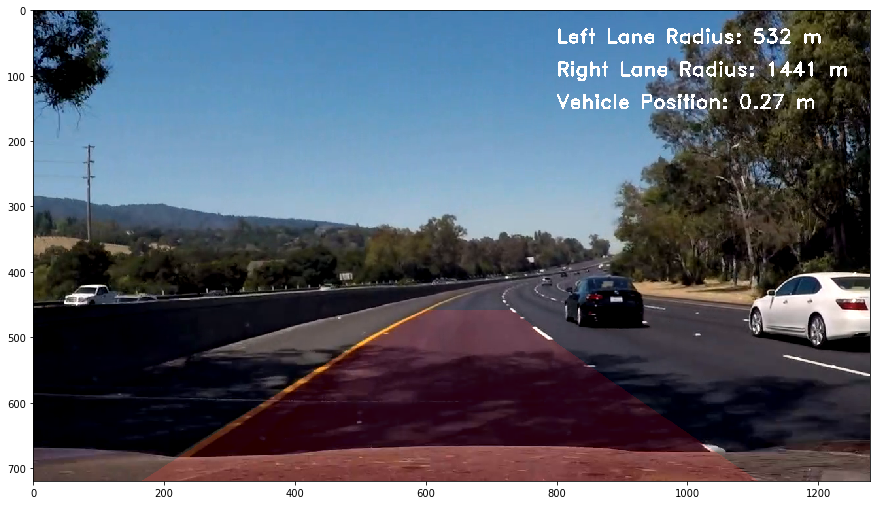

In [64]:
FINAL = process_image(test_image3)
plt.figure(figsize=(15,15))
plt.imshow(FINAL)
#plt.savefig("output_images/Displaying_Final_Result_Straight_Lines_2.jpg",bbox="tight")

# Pipeline for the video

In [65]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [66]:
l.count = 0
abcwhite_output = 'test1_output.mp4'#'output_images/project_video_output.mp4'
clip1 = VideoFileClip("test1.mp4")#("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(abcwhite_output, audio=False)

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 1
[MoviePy] >>>> Building video test1_output.mp4
[MoviePy] Writing video test1_output.mp4



  0%|          | 1/251 [00:00<02:12,  1.88it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 2



  1%|          | 2/251 [00:01<02:10,  1.91it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 3



  1%|          | 3/251 [00:01<02:10,  1.90it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 4



  2%|▏         | 4/251 [00:02<02:08,  1.93it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 5



  2%|▏         | 5/251 [00:02<02:05,  1.96it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 6



  2%|▏         | 6/251 [00:03<02:06,  1.93it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 7



  3%|▎         | 7/251 [00:03<02:04,  1.95it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 8



  3%|▎         | 8/251 [00:04<02:02,  1.98it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 9



  4%|▎         | 9/251 [00:04<02:03,  1.96it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 10



  4%|▍         | 10/251 [00:05<02:01,  1.99it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 11



  4%|▍         | 11/251 [00:05<01:59,  2.01it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 12



  5%|▍         | 12/251 [00:06<02:00,  1.98it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 13


  5%|▌         | 13/251 [00:06<01:59,  2.00it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 14


  6%|▌         | 14/251 [00:07<01:57,  2.02it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 15


  6%|▌         | 15/251 [00:07<01:58,  2.00it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 16


  6%|▋         | 16/251 [00:08<01:57,  2.01it/s]

[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] True
[  2.41672691e-04  -4.21275086e-01   4.36228418e+02] [  1.46586188e-04  -4.74768477e-02   1.00530467e+03] 15


  7%|▋         | 17/251 [00:08<01:56,  2.01it/s]

[  2.55184730e-04  -4.38438934e-01   4.42249257e+02] [  9.19713059e-05  -1.16783396e-02   9.98705904e+02] True
[  2.55184730e-04  -4.38438934e-01   4.42249257e+02] [  9.19713059e-05  -1.16783396e-02   9.98705904e+02] 16


  7%|▋         | 18/251 [00:09<01:57,  1.98it/s]

[  2.60288647e-04  -4.40378226e-01   4.41755893e+02] [  6.55380604e-05   1.07202766e-02   9.94195706e+02] True
[  2.60288647e-04  -4.40378226e-01   4.41755893e+02] [  6.55380604e-05   1.07202766e-02   9.94195706e+02] 15


  8%|▊         | 19/251 [00:09<01:56,  1.99it/s]

[  2.57710018e-04  -4.40241633e-01   4.41075782e+02] [  1.15987200e-04  -1.30625965e-02   9.96667582e+02] True
[  2.57710018e-04  -4.40241633e-01   4.41075782e+02] [  1.15987200e-04  -1.30625965e-02   9.96667582e+02] 16


  8%|▊         | 20/251 [00:10<01:55,  1.99it/s]

[  2.67695344e-04  -4.49683410e-01   4.42532061e+02] [  1.54576000e-04  -3.07622554e-02   9.96941882e+02] True
[  2.67695344e-04  -4.49683410e-01   4.42532061e+02] [  1.54576000e-04  -3.07622554e-02   9.96941882e+02] 15


  8%|▊         | 21/251 [00:10<01:58,  1.95it/s]

[  2.68286993e-04  -4.51029289e-01   4.41597208e+02] [  1.60421568e-04  -3.28533516e-02   9.97561413e+02] True
[  2.68286993e-04  -4.51029289e-01   4.41597208e+02] [  1.60421568e-04  -3.28533516e-02   9.97561413e+02] 16


  9%|▉         | 22/251 [00:11<01:59,  1.92it/s]

[  2.72654529e-04  -4.63119010e-01   4.47073446e+02] [  1.43001610e-04  -2.31042280e-02   9.94076717e+02] True
[  2.72654529e-04  -4.63119010e-01   4.47073446e+02] [  1.43001610e-04  -2.31042280e-02   9.94076717e+02] 15


  9%|▉         | 23/251 [00:11<01:57,  1.95it/s]

[  2.98526828e-04  -4.89730631e-01   4.54445890e+02] [  1.66148917e-04  -3.54228778e-02   9.92959885e+02] True
[  2.98526828e-04  -4.89730631e-01   4.54445890e+02] [  1.66148917e-04  -3.54228778e-02   9.92959885e+02] 16


 10%|▉         | 24/251 [00:12<01:56,  1.94it/s]

[  2.89304436e-04  -4.85812269e-01   4.55783318e+02] [  1.60252357e-04  -2.68944575e-02   9.90501090e+02] True
[  2.89304436e-04  -4.85812269e-01   4.55783318e+02] [  1.60252357e-04  -2.68944575e-02   9.90501090e+02] 15


 10%|▉         | 25/251 [00:12<01:54,  1.97it/s]

[  2.97289188e-04  -5.03682533e-01   4.63797991e+02] [  2.36303673e-04  -7.86909261e-02   9.93580575e+02] True
[  2.97289188e-04  -5.03682533e-01   4.63797991e+02] [  2.36303673e-04  -7.86909261e-02   9.93580575e+02] 16


 10%|█         | 26/251 [00:13<01:52,  2.00it/s]

[  2.92680321e-04  -5.01693244e-01   4.65462719e+02] [  2.58232224e-04  -9.07068658e-02   9.93830542e+02] True
[  2.92680321e-04  -5.01693244e-01   4.65462719e+02] [  2.58232224e-04  -9.07068658e-02   9.93830542e+02] 15


 11%|█         | 27/251 [00:13<01:53,  1.97it/s]

[  2.94088441e-04  -4.97046103e-01   4.61285353e+02] [  2.47121129e-04  -8.40867016e-02   9.96105226e+02] True
[  2.94088441e-04  -4.97046103e-01   4.61285353e+02] [  2.47121129e-04  -8.40867016e-02   9.96105226e+02] 16


 11%|█         | 28/251 [00:14<01:51,  1.99it/s]

[  2.62271048e-04  -4.79950586e-01   4.60177808e+02] [  1.50675386e-04  -3.45747895e-02   9.91036422e+02] True
[  2.62271048e-04  -4.79950586e-01   4.60177808e+02] [  1.50675386e-04  -3.45747895e-02   9.91036422e+02] 15


 12%|█▏        | 29/251 [00:14<01:50,  2.01it/s]

[  2.66007338e-04  -4.84905610e-01   4.61491345e+02] [  8.36135709e-05   1.74664804e-04   9.88156329e+02] True
[  2.66007338e-04  -4.84905610e-01   4.61491345e+02] [  8.36135709e-05   1.74664804e-04   9.88156329e+02] 16


 12%|█▏        | 30/251 [00:15<01:51,  1.98it/s]

[  2.63053735e-04  -4.89369690e-01   4.64581833e+02] [  1.47023252e-04  -3.52833614e-02   9.90702220e+02] True
[  2.63053735e-04  -4.89369690e-01   4.64581833e+02] [  1.47023252e-04  -3.52833614e-02   9.90702220e+02] 15


 12%|█▏        | 31/251 [00:15<01:51,  1.98it/s]

[  2.43354601e-04  -4.74702236e-01   4.60937174e+02] [  1.58246464e-04  -4.68555378e-02   9.95093141e+02] True
[  2.43354601e-04  -4.74702236e-01   4.60937174e+02] [  1.58246464e-04  -4.68555378e-02   9.95093141e+02] 16


 13%|█▎        | 32/251 [00:16<01:50,  1.98it/s]

[  2.32558933e-04  -4.65482867e-01   4.57835661e+02] [  1.47291382e-04  -3.78128578e-02   9.94305994e+02] True
[  2.32558933e-04  -4.65482867e-01   4.57835661e+02] [  1.47291382e-04  -3.78128578e-02   9.94305994e+02] 15


 13%|█▎        | 33/251 [00:16<01:51,  1.96it/s]

[  2.27774290e-04  -4.62204779e-01   4.57108873e+02] [  1.65170984e-04  -4.34243611e-02   9.92857617e+02] True
[  2.27774290e-04  -4.62204779e-01   4.57108873e+02] [  1.65170984e-04  -4.34243611e-02   9.92857617e+02] 16


 14%|█▎        | 34/251 [00:17<01:49,  1.98it/s]

[  2.23528724e-04  -4.61782683e-01   4.58753234e+02] [  2.20045530e-04  -7.39631332e-02   9.92756412e+02] True
[  2.23528724e-04  -4.61782683e-01   4.58753234e+02] [  2.20045530e-04  -7.39631332e-02   9.92756412e+02] 15


 14%|█▍        | 35/251 [00:17<01:47,  2.00it/s]

[  2.32112903e-04  -4.69584864e-01   4.61229163e+02] [  2.29540963e-04  -8.01327026e-02   9.93243075e+02] True
[  2.32112903e-04  -4.69584864e-01   4.61229163e+02] [  2.29540963e-04  -8.01327026e-02   9.93243075e+02] 16


 14%|█▍        | 36/251 [00:18<01:49,  1.97it/s]

[  2.17323769e-04  -4.55039908e-01   4.57882944e+02] [  2.39923249e-04  -8.89325834e-02   9.94395113e+02] True
[  2.17323769e-04  -4.55039908e-01   4.57882944e+02] [  2.39923249e-04  -8.89325834e-02   9.94395113e+02] 15


 15%|█▍        | 37/251 [00:18<01:47,  1.98it/s]

[  2.26096725e-04  -4.58038823e-01   4.55370964e+02] [  2.45465606e-04  -9.93687903e-02   9.99253450e+02] True
[  2.26096725e-04  -4.58038823e-01   4.55370964e+02] [  2.45465606e-04  -9.93687903e-02   9.99253450e+02] 16


 15%|█▌        | 38/251 [00:19<01:47,  1.99it/s]

[  2.32733790e-04  -4.60220310e-01   4.53872427e+02] [  2.65695427e-04  -1.18284578e-01   1.00378403e+03] True
[  2.32733790e-04  -4.60220310e-01   4.53872427e+02] [  2.65695427e-04  -1.18284578e-01   1.00378403e+03] 15


 16%|█▌        | 39/251 [00:19<01:47,  1.97it/s]

[  2.48516404e-04  -4.70539869e-01   4.58288106e+02] [  2.36745618e-04  -9.30843821e-02   9.97243614e+02] True
[  2.48516404e-04  -4.70539869e-01   4.58288106e+02] [  2.36745618e-04  -9.30843821e-02   9.97243614e+02] 16


 16%|█▌        | 40/251 [00:20<01:45,  2.00it/s]

[  2.49326980e-04  -4.80928237e-01   4.64909550e+02] [  1.77775627e-04  -6.62819878e-02   9.93741958e+02] True
[  2.49326980e-04  -4.80928237e-01   4.64909550e+02] [  1.77775627e-04  -6.62819878e-02   9.93741958e+02] 15


 16%|█▋        | 41/251 [00:20<01:44,  2.02it/s]

[  2.45081572e-04  -4.76377382e-01   4.64789807e+02] [  8.07931755e-05  -1.71827023e-02   9.90705781e+02] True
[  2.45081572e-04  -4.76377382e-01   4.64789807e+02] [  8.07931755e-05  -1.71827023e-02   9.90705781e+02] 16


 17%|█▋        | 42/251 [00:21<01:44,  1.99it/s]

[  2.39447720e-04  -4.65725900e-01   4.59494596e+02] [  1.06104558e-04  -3.69339906e-02   9.99632308e+02] True
[  2.39447720e-04  -4.65725900e-01   4.59494596e+02] [  1.06104558e-04  -3.69339906e-02   9.99632308e+02] 15


 17%|█▋        | 43/251 [00:21<01:57,  1.77it/s]

[  2.22833491e-04  -4.49604338e-01   4.54862122e+02] [  7.85905382e-05  -2.56665007e-02   1.00395252e+03] True
[  2.22833491e-04  -4.49604338e-01   4.54862122e+02] [  7.85905382e-05  -2.56665007e-02   1.00395252e+03] 16


 18%|█▊        | 44/251 [00:22<01:53,  1.82it/s]

[  2.19138621e-04  -4.46684050e-01   4.55940818e+02] [  1.55466039e-04  -7.47533585e-02   1.01147966e+03] True
[  2.19138621e-04  -4.46684050e-01   4.55940818e+02] [  1.55466039e-04  -7.47533585e-02   1.01147966e+03] 15


 18%|█▊        | 45/251 [00:22<01:53,  1.82it/s]

[  2.06591526e-04  -4.38057568e-01   4.53809671e+02] [  1.91827946e-04  -9.70367178e-02   1.01666700e+03] True
[  2.06591526e-04  -4.38057568e-01   4.53809671e+02] [  1.91827946e-04  -9.70367178e-02   1.01666700e+03] 16


 18%|█▊        | 46/251 [00:23<01:52,  1.83it/s]

[  2.00582200e-04  -4.32612231e-01   4.53293112e+02] [  1.72944619e-04  -8.55262246e-02   1.01873896e+03] True
[  2.00582200e-04  -4.32612231e-01   4.53293112e+02] [  1.72944619e-04  -8.55262246e-02   1.01873896e+03] 15


 19%|█▊        | 47/251 [00:24<01:49,  1.87it/s]

[  2.07549129e-04  -4.34798218e-01   4.53115799e+02] [  1.65571524e-04  -7.75864830e-02   1.01962917e+03] True
[  2.07549129e-04  -4.34798218e-01   4.53115799e+02] [  1.65571524e-04  -7.75864830e-02   1.01962917e+03] 16


 19%|█▉        | 48/251 [00:24<01:49,  1.85it/s]

[  2.05951382e-04  -4.34062684e-01   4.53927653e+02] [  1.86240656e-04  -9.04974855e-02   1.02302653e+03] True
[  2.05951382e-04  -4.34062684e-01   4.53927653e+02] [  1.86240656e-04  -9.04974855e-02   1.02302653e+03] 15


 20%|█▉        | 49/251 [00:25<01:48,  1.87it/s]

[  1.85571381e-04  -4.21025840e-01   4.52637713e+02] [  2.10354703e-04  -1.13140597e-01   1.02913603e+03] True
[  1.85571381e-04  -4.21025840e-01   4.52637713e+02] [  2.10354703e-04  -1.13140597e-01   1.02913603e+03] 16


 20%|█▉        | 50/251 [00:25<01:45,  1.91it/s]

[  1.83669767e-04  -4.13982038e-01   4.48532368e+02] [  1.94589393e-04  -1.05089356e-01   1.03439146e+03] True
[  1.83669767e-04  -4.13982038e-01   4.48532368e+02] [  1.94589393e-04  -1.05089356e-01   1.03439146e+03] 15


 20%|██        | 51/251 [00:26<01:45,  1.89it/s]

[  2.21722051e-04  -4.42544347e-01   4.56093841e+02] [  2.23830581e-04  -1.25182502e-01   1.03633338e+03] True
[  2.21722051e-04  -4.42544347e-01   4.56093841e+02] [  2.23830581e-04  -1.25182502e-01   1.03633338e+03] 16


 21%|██        | 52/251 [00:26<01:46,  1.87it/s]

[  2.26200512e-04  -4.52596618e-01   4.60943090e+02] [  1.94865843e-04  -1.09357210e-01   1.03636403e+03] True
[  2.26200512e-04  -4.52596618e-01   4.60943090e+02] [  1.94865843e-04  -1.09357210e-01   1.03636403e+03] 15


 21%|██        | 53/251 [00:27<01:44,  1.89it/s]

[  2.24375996e-04  -4.54309676e-01   4.64141923e+02] [  1.41876753e-04  -8.70816003e-02   1.03492704e+03] True
[  2.24375996e-04  -4.54309676e-01   4.64141923e+02] [  1.41876753e-04  -8.70816003e-02   1.03492704e+03] 16


 22%|██▏       | 54/251 [00:27<01:44,  1.89it/s]

[  2.37270724e-04  -4.66186992e-01   4.68158080e+02] [  1.39897220e-04  -7.85896602e-02   1.03411737e+03] True
[  2.37270724e-04  -4.66186992e-01   4.68158080e+02] [  1.39897220e-04  -7.85896602e-02   1.03411737e+03] 15


 22%|██▏       | 55/251 [00:28<01:42,  1.91it/s]

[  2.34780770e-04  -4.64537881e-01   4.69306532e+02] [  1.37924667e-04  -7.42000386e-02   1.03551749e+03] True
[  2.34780770e-04  -4.64537881e-01   4.69306532e+02] [  1.37924667e-04  -7.42000386e-02   1.03551749e+03] 16


 22%|██▏       | 56/251 [00:28<01:44,  1.86it/s]

[  2.57163286e-04  -4.84333495e-01   4.76383024e+02] [  1.45744440e-04  -7.60025456e-02   1.03425200e+03] True
[  2.57163286e-04  -4.84333495e-01   4.76383024e+02] [  1.45744440e-04  -7.60025456e-02   1.03425200e+03] 15


 23%|██▎       | 57/251 [00:29<01:45,  1.84it/s]

[  2.58801611e-04  -4.96102057e-01   4.84269836e+02] [  1.67356519e-04  -9.00000109e-02   1.03376335e+03] True
[  2.58801611e-04  -4.96102057e-01   4.84269836e+02] [  1.67356519e-04  -9.00000109e-02   1.03376335e+03] 16


 23%|██▎       | 58/251 [00:29<01:42,  1.88it/s]

[  2.73807851e-04  -5.16898761e-01   4.93621617e+02] [  1.77569037e-04  -8.43007041e-02   1.02838872e+03] True
[  2.73807851e-04  -5.16898761e-01   4.93621617e+02] [  1.77569037e-04  -8.43007041e-02   1.02838872e+03] 15


 24%|██▎       | 59/251 [00:30<01:40,  1.91it/s]

[  2.64583022e-04  -5.09622855e-01   4.92630036e+02] [  2.00597537e-04  -9.39067324e-02   1.02837653e+03] True
[  2.64583022e-04  -5.09622855e-01   4.92630036e+02] [  2.00597537e-04  -9.39067324e-02   1.02837653e+03] 16


 24%|██▍       | 60/251 [00:31<01:45,  1.82it/s]

[  2.62824695e-04  -5.07162450e-01   4.91986860e+02] [  2.06142494e-04  -1.00464934e-01   1.03173955e+03] True
[  2.62824695e-04  -5.07162450e-01   4.91986860e+02] [  2.06142494e-04  -1.00464934e-01   1.03173955e+03] 15


 24%|██▍       | 61/251 [00:31<01:45,  1.80it/s]

[  2.58996178e-04  -5.05241785e-01   4.93683553e+02] [  2.14812227e-04  -1.04332263e-01   1.03216995e+03] True
[  2.58996178e-04  -5.05241785e-01   4.93683553e+02] [  2.14812227e-04  -1.04332263e-01   1.03216995e+03] 16


 25%|██▍       | 62/251 [00:32<01:46,  1.78it/s]

[  2.76866150e-04  -5.15365416e-01   4.95161640e+02] [  2.52579843e-04  -1.37922980e-01   1.04027946e+03] True
[  2.76866150e-04  -5.15365416e-01   4.95161640e+02] [  2.52579843e-04  -1.37922980e-01   1.04027946e+03] 15


 25%|██▌       | 63/251 [00:32<01:46,  1.77it/s]

[  2.91204052e-04  -5.25447083e-01   4.99972161e+02] [  2.54701434e-04  -1.29630938e-01   1.03746176e+03] True
[  2.91204052e-04  -5.25447083e-01   4.99972161e+02] [  2.54701434e-04  -1.29630938e-01   1.03746176e+03] 16


 25%|██▌       | 64/251 [00:33<01:44,  1.79it/s]

[  2.79602532e-04  -5.11886500e-01   4.96304447e+02] [  1.92294399e-04  -1.09799331e-01   1.04161629e+03] True
[  2.79602532e-04  -5.11886500e-01   4.96304447e+02] [  1.92294399e-04  -1.09799331e-01   1.04161629e+03] 15


 26%|██▌       | 65/251 [00:33<01:45,  1.76it/s]

[  2.68407028e-04  -5.10513953e-01   5.01033786e+02] [  1.21125598e-04  -6.37082209e-02   1.03326264e+03] True
[  2.68407028e-04  -5.10513953e-01   5.01033786e+02] [  1.21125598e-04  -6.37082209e-02   1.03326264e+03] 16


 26%|██▋       | 66/251 [00:34<01:45,  1.75it/s]

[  2.48692779e-04  -4.97646348e-01   5.00445052e+02] [  1.68477372e-04  -9.13328182e-02   1.03744670e+03] True
[  2.48692779e-04  -4.97646348e-01   5.00445052e+02] [  1.68477372e-04  -9.13328182e-02   1.03744670e+03] 15


 27%|██▋       | 67/251 [00:34<01:43,  1.77it/s]

[  2.52136275e-04  -5.03157987e-01   5.04409916e+02] [  1.96722010e-04  -1.04302011e-01   1.03688727e+03] True
[  2.52136275e-04  -5.03157987e-01   5.04409916e+02] [  1.96722010e-04  -1.04302011e-01   1.03688727e+03] 16


 27%|██▋       | 68/251 [00:35<01:45,  1.74it/s]

[  2.61856742e-04  -5.07795085e-01   5.05509257e+02] [  2.26411185e-04  -1.21568329e-01   1.03966850e+03] True
[  2.61856742e-04  -5.07795085e-01   5.05509257e+02] [  2.26411185e-04  -1.21568329e-01   1.03966850e+03] 15


 27%|██▋       | 69/251 [00:36<01:45,  1.72it/s]

[  2.62491775e-04  -5.11156023e-01   5.08324729e+02] [  2.03429403e-04  -9.98871626e-02   1.03369685e+03] True
[  2.62491775e-04  -5.11156023e-01   5.08324729e+02] [  2.03429403e-04  -9.98871626e-02   1.03369685e+03] 16


 28%|██▊       | 70/251 [00:36<01:44,  1.74it/s]

[  2.49818821e-04  -4.98164135e-01   5.05021466e+02] [  2.42569315e-04  -1.27638557e-01   1.03994818e+03] True
[  2.49818821e-04  -4.98164135e-01   5.05021466e+02] [  2.42569315e-04  -1.27638557e-01   1.03994818e+03] 15


 28%|██▊       | 71/251 [00:37<01:45,  1.70it/s]

[  2.34474423e-04  -4.84508622e-01   5.02353163e+02] [  2.57590110e-04  -1.41258092e-01   1.04494106e+03] True
[  2.34474423e-04  -4.84508622e-01   5.02353163e+02] [  2.57590110e-04  -1.41258092e-01   1.04494106e+03] 16


 29%|██▊       | 72/251 [00:37<01:43,  1.72it/s]

[  2.18664125e-04  -4.67704423e-01   4.99498359e+02] [  2.42385527e-04  -1.28514314e-01   1.04623310e+03] True
[  2.18664125e-04  -4.67704423e-01   4.99498359e+02] [  2.42385527e-04  -1.28514314e-01   1.04623310e+03] 15


 29%|██▉       | 73/251 [00:38<01:45,  1.68it/s]

[  2.07468833e-04  -4.55487008e-01   4.96286890e+02] [  2.65708311e-04  -1.51615922e-01   1.05380855e+03] True
[  2.07468833e-04  -4.55487008e-01   4.96286890e+02] [  2.65708311e-04  -1.51615922e-01   1.05380855e+03] 16


 29%|██▉       | 74/251 [00:39<01:42,  1.72it/s]

[  1.97342924e-04  -4.43681670e-01   4.93775622e+02] [  2.76731833e-04  -1.71153486e-01   1.06338946e+03] True
[  1.97342924e-04  -4.43681670e-01   4.93775622e+02] [  2.76731833e-04  -1.71153486e-01   1.06338946e+03] 15


 30%|██▉       | 75/251 [00:39<01:43,  1.70it/s]

[  2.13960558e-04  -4.55701285e-01   4.98223263e+02] [  2.77406573e-04  -1.65968893e-01   1.06247718e+03] True
[  2.13960558e-04  -4.55701285e-01   4.98223263e+02] [  2.77406573e-04  -1.65968893e-01   1.06247718e+03] 16


 30%|███       | 76/251 [00:40<01:41,  1.73it/s]

[  2.00201375e-04  -4.45776912e-01   4.98400165e+02] [  2.36154202e-04  -1.55230240e-01   1.06668634e+03] True
[  2.00201375e-04  -4.45776912e-01   4.98400165e+02] [  2.36154202e-04  -1.55230240e-01   1.06668634e+03] 15


 31%|███       | 77/251 [00:40<01:41,  1.71it/s]

[  1.88856919e-04  -4.36118803e-01   4.96906018e+02] [  2.24136022e-04  -1.53387187e-01   1.07189500e+03] True
[  1.88856919e-04  -4.36118803e-01   4.96906018e+02] [  2.24136022e-04  -1.53387187e-01   1.07189500e+03] 16


 31%|███       | 78/251 [00:41<01:39,  1.74it/s]

[  1.91337026e-04  -4.41384015e-01   5.00956388e+02] [  2.03239388e-04  -1.35833734e-01   1.07014114e+03] True
[  1.91337026e-04  -4.41384015e-01   5.00956388e+02] [  2.03239388e-04  -1.35833734e-01   1.07014114e+03] 15


 31%|███▏      | 79/251 [00:42<01:39,  1.72it/s]

[  2.05779957e-04  -4.56456888e-01   5.10067739e+02] [  2.10213592e-04  -1.37049643e-01   1.06902385e+03] True
[  2.05779957e-04  -4.56456888e-01   5.10067739e+02] [  2.10213592e-04  -1.37049643e-01   1.06902385e+03] 16


 32%|███▏      | 80/251 [00:42<01:37,  1.75it/s]

[  2.08364059e-04  -4.60871785e-01   5.13982878e+02] [  2.49507523e-04  -1.62843223e-01   1.07377223e+03] True
[  2.08364059e-04  -4.60871785e-01   5.13982878e+02] [  2.49507523e-04  -1.62843223e-01   1.07377223e+03] 15


 32%|███▏      | 81/251 [00:43<01:38,  1.73it/s]

[  2.09813566e-04  -4.52736951e-01   5.09842524e+02] [  2.76164805e-04  -1.87009240e-01   1.08417005e+03] True
[  2.09813566e-04  -4.52736951e-01   5.09842524e+02] [  2.76164805e-04  -1.87009240e-01   1.08417005e+03] 16


 33%|███▎      | 82/251 [00:43<01:38,  1.72it/s]

[  2.06347794e-04  -4.44372692e-01   5.07294324e+02] [  2.56084956e-04  -1.74835555e-01   1.08545381e+03] True
[  2.06347794e-04  -4.44372692e-01   5.07294324e+02] [  2.56084956e-04  -1.74835555e-01   1.08545381e+03] 15


 33%|███▎      | 83/251 [00:44<01:42,  1.64it/s]

[  1.92813782e-04  -4.28372372e-01   5.02720696e+02] [  2.01632232e-04  -1.39090550e-01   1.08356854e+03] True
[  1.92813782e-04  -4.28372372e-01   5.02720696e+02] [  2.01632232e-04  -1.39090550e-01   1.08356854e+03] 16


 33%|███▎      | 84/251 [00:44<01:38,  1.70it/s]

[  1.91826078e-04  -4.21757095e-01   5.00248794e+02] [  1.81558701e-04  -1.19179041e-01   1.08108711e+03] True
[  1.91826078e-04  -4.21757095e-01   5.00248794e+02] [  1.81558701e-04  -1.19179041e-01   1.08108711e+03] 15


 34%|███▍      | 85/251 [00:45<01:37,  1.70it/s]

[  1.91629783e-04  -4.21288606e-01   5.00574970e+02] [  1.67880931e-04  -1.03473080e-01   1.07878602e+03] True
[  1.91629783e-04  -4.21288606e-01   5.00574970e+02] [  1.67880931e-04  -1.03473080e-01   1.07878602e+03] 16


 34%|███▍      | 86/251 [00:46<01:34,  1.75it/s]

[  1.95498389e-04  -4.22890922e-01   5.00577873e+02] [  1.93100110e-04  -1.22929628e-01   1.08090839e+03] True
[  1.95498389e-04  -4.22890922e-01   5.00577873e+02] [  1.93100110e-04  -1.22929628e-01   1.08090839e+03] 15


 35%|███▍      | 87/251 [00:46<01:35,  1.72it/s]

[  2.19307261e-04  -4.27414696e-01   4.95911887e+02] [  1.88144588e-04  -1.20898239e-01   1.08444332e+03] True
[  2.19307261e-04  -4.27414696e-01   4.95911887e+02] [  1.88144588e-04  -1.20898239e-01   1.08444332e+03] 16


 35%|███▌      | 88/251 [00:47<01:32,  1.76it/s]

[  2.26847801e-04  -4.32959763e-01   4.96178932e+02] [  2.13211153e-04  -1.38678359e-01   1.08661860e+03] True
[  2.26847801e-04  -4.32959763e-01   4.96178932e+02] [  2.13211153e-04  -1.38678359e-01   1.08661860e+03] 15


 35%|███▌      | 89/251 [00:47<01:40,  1.62it/s]

[  2.28087073e-04  -4.31377689e-01   4.94550791e+02] [  1.49010689e-04  -9.96910948e-02   1.08339874e+03] True
[  2.28087073e-04  -4.31377689e-01   4.94550791e+02] [  1.49010689e-04  -9.96910948e-02   1.08339874e+03] 16


 36%|███▌      | 90/251 [00:48<01:44,  1.55it/s]

[  2.39268933e-04  -4.35462412e-01   4.93592453e+02] [  1.62380706e-04  -1.03435311e-01   1.08374639e+03] True
[  2.39268933e-04  -4.35462412e-01   4.93592453e+02] [  1.62380706e-04  -1.03435311e-01   1.08374639e+03] 15


 36%|███▋      | 91/251 [00:49<01:42,  1.55it/s]

[  2.55674708e-04  -4.51813155e-01   4.98722127e+02] [  1.56233264e-04  -8.67166667e-02   1.07711063e+03] True
[  2.55674708e-04  -4.51813155e-01   4.98722127e+02] [  1.56233264e-04  -8.67166667e-02   1.07711063e+03] 16


 37%|███▋      | 92/251 [00:50<01:56,  1.37it/s]

[  2.69677620e-04  -4.56534303e-01   4.96847029e+02] [  1.40114853e-04  -7.51285423e-02   1.07671328e+03] True
[  2.69677620e-04  -4.56534303e-01   4.96847029e+02] [  1.40114853e-04  -7.51285423e-02   1.07671328e+03] 15


 37%|███▋      | 93/251 [00:51<02:08,  1.23it/s]

[  2.79012034e-04  -4.69021659e-01   5.01084639e+02] [  1.39654991e-04  -6.97456929e-02   1.07358175e+03] True
[  2.79012034e-04  -4.69021659e-01   5.01084639e+02] [  1.39654991e-04  -6.97456929e-02   1.07358175e+03] 16


 37%|███▋      | 94/251 [00:52<02:18,  1.13it/s]

[  2.90188489e-04  -4.82805371e-01   5.06965107e+02] [  1.44221453e-04  -6.28421080e-02   1.06756023e+03] True
[  2.90188489e-04  -4.82805371e-01   5.06965107e+02] [  1.44221453e-04  -6.28421080e-02   1.06756023e+03] 15


 38%|███▊      | 95/251 [00:53<02:28,  1.05it/s]

[  2.87213826e-04  -4.83979216e-01   5.09427484e+02] [  9.33268944e-05  -2.20977767e-02   1.06161900e+03] True
[  2.87213826e-04  -4.83979216e-01   5.09427484e+02] [  9.33268944e-05  -2.20977767e-02   1.06161900e+03] 16


 38%|███▊      | 96/251 [00:54<02:30,  1.03it/s]

[  2.91574409e-04  -4.86152626e-01   5.08973998e+02] [  1.15427788e-04  -3.24881517e-02   1.06401067e+03] True
[  2.91574409e-04  -4.86152626e-01   5.08973998e+02] [  1.15427788e-04  -3.24881517e-02   1.06401067e+03] 15


 39%|███▊      | 97/251 [00:55<02:31,  1.01it/s]

[  2.66322690e-04  -4.60603439e-01   5.00765533e+02] [  1.25041083e-04  -3.44473314e-02   1.06690535e+03] True
[  2.66322690e-04  -4.60603439e-01   5.00765533e+02] [  1.25041083e-04  -3.44473314e-02   1.06690535e+03] 16


 39%|███▉      | 98/251 [00:56<02:20,  1.09it/s]

[  2.77808716e-04  -4.69959204e-01   5.00503707e+02] [  1.24080492e-04  -3.70037903e-02   1.07023615e+03] True
[  2.77808716e-04  -4.69959204e-01   5.00503707e+02] [  1.24080492e-04  -3.70037903e-02   1.07023615e+03] 15


 39%|███▉      | 99/251 [00:56<02:02,  1.24it/s]

[  2.78111734e-04  -4.68620873e-01   5.00415756e+02] [  1.67890713e-04  -6.48859650e-02   1.07223995e+03] True
[  2.78111734e-04  -4.68620873e-01   5.00415756e+02] [  1.67890713e-04  -6.48859650e-02   1.07223995e+03] 16


 40%|███▉      | 100/251 [00:57<01:51,  1.36it/s]

[  2.92987098e-04  -4.77386403e-01   5.01035862e+02] [  1.95178386e-04  -8.04945940e-02   1.07332044e+03] True
[  2.92987098e-04  -4.77386403e-01   5.01035862e+02] [  1.95178386e-04  -8.04945940e-02   1.07332044e+03] 15


 40%|████      | 101/251 [00:57<01:41,  1.48it/s]

[  2.56447601e-04  -4.59335937e-01   5.02594798e+02] [  1.28406699e-04  -3.70490363e-02   1.06483245e+03] True
[  2.56447601e-04  -4.59335937e-01   5.02594798e+02] [  1.28406699e-04  -3.70490363e-02   1.06483245e+03] 16


 41%|████      | 102/251 [00:58<01:36,  1.55it/s]

[  2.53752036e-04  -4.61388948e-01   5.05582011e+02] [  9.53087977e-05  -6.63015002e-03   1.05621677e+03] True
[  2.53752036e-04  -4.61388948e-01   5.05582011e+02] [  9.53087977e-05  -6.63015002e-03   1.05621677e+03] 15


 41%|████      | 103/251 [00:58<01:30,  1.64it/s]

[  2.43332391e-04  -4.60654529e-01   5.09296779e+02] [  1.19402465e-04  -2.17863861e-02   1.05378156e+03] True
[  2.43332391e-04  -4.60654529e-01   5.09296779e+02] [  1.19402465e-04  -2.17863861e-02   1.05378156e+03] 16


 41%|████▏     | 104/251 [00:59<01:28,  1.65it/s]

[  2.36973806e-04  -4.54541690e-01   5.08203254e+02] [  1.39314251e-04  -2.19736814e-02   1.05070149e+03] True
[  2.36973806e-04  -4.54541690e-01   5.08203254e+02] [  1.39314251e-04  -2.19736814e-02   1.05070149e+03] 15


 42%|████▏     | 105/251 [01:00<01:25,  1.71it/s]

[  2.22262846e-04  -4.40610782e-01   5.04317739e+02] [  1.12808400e-04  -3.25306838e-03   1.04824721e+03] True
[  2.22262846e-04  -4.40610782e-01   5.04317739e+02] [  1.12808400e-04  -3.25306838e-03   1.04824721e+03] 16


 42%|████▏     | 106/251 [01:00<01:25,  1.69it/s]

[  2.08060274e-04  -4.22919820e-01   4.98029687e+02] [  9.78068239e-05   1.40417666e-02   1.04557848e+03] True
[  2.08060274e-04  -4.22919820e-01   4.98029687e+02] [  9.78068239e-05   1.40417666e-02   1.04557848e+03] 15


 43%|████▎     | 107/251 [01:01<01:24,  1.71it/s]

[  1.99718192e-04  -4.02746648e-01   4.87122265e+02] [  1.44248803e-04  -1.85302062e-02   1.05445123e+03] True
[  1.99718192e-04  -4.02746648e-01   4.87122265e+02] [  1.44248803e-04  -1.85302062e-02   1.05445123e+03] 16


 43%|████▎     | 108/251 [01:01<01:22,  1.73it/s]

[  1.89338373e-04  -3.97334677e-01   4.87076665e+02] [  1.22306706e-04   2.93501398e-03   1.04683908e+03] True
[  1.89338373e-04  -3.97334677e-01   4.87076665e+02] [  1.22306706e-04   2.93501398e-03   1.04683908e+03] 15


 43%|████▎     | 109/251 [01:02<01:23,  1.70it/s]

[  1.91032330e-04  -3.93745540e-01   4.83684782e+02] [  1.74316706e-04  -3.17093949e-02   1.05035639e+03] True
[  1.91032330e-04  -3.93745540e-01   4.83684782e+02] [  1.74316706e-04  -3.17093949e-02   1.05035639e+03] 16


 44%|████▍     | 110/251 [01:03<01:21,  1.72it/s]

[  1.80445058e-04  -3.76424426e-01   4.76287708e+02] [  1.75091283e-04  -3.32442782e-02   1.05228373e+03] True
[  1.80445058e-04  -3.76424426e-01   4.76287708e+02] [  1.75091283e-04  -3.32442782e-02   1.05228373e+03] 15


 44%|████▍     | 111/251 [01:03<01:23,  1.67it/s]

[  2.06128743e-04  -3.96834645e-01   4.82060608e+02] [  2.09894177e-04  -5.82785878e-02   1.05351442e+03] True
[  2.06128743e-04  -3.96834645e-01   4.82060608e+02] [  2.09894177e-04  -5.82785878e-02   1.05351442e+03] 16


 45%|████▍     | 112/251 [01:04<01:22,  1.68it/s]

[  1.93022607e-04  -3.83905889e-01   4.78060352e+02] [  1.81984239e-04  -4.53117436e-02   1.05284707e+03] True
[  1.93022607e-04  -3.83905889e-01   4.78060352e+02] [  1.81984239e-04  -4.53117436e-02   1.05284707e+03] 15


 45%|████▌     | 113/251 [01:04<01:22,  1.68it/s]

[  1.94427851e-04  -3.89955545e-01   4.81823001e+02] [  4.56821174e-05   2.52333273e-02   1.04162073e+03] True
[  1.94427851e-04  -3.89955545e-01   4.81823001e+02] [  4.56821174e-05   2.52333273e-02   1.04162073e+03] 16


 45%|████▌     | 114/251 [01:05<01:19,  1.72it/s]

[  2.01683270e-04  -3.96679024e-01   4.85339268e+02] [  1.04646135e-05   5.81416043e-02   1.03267441e+03] True
[  2.01683270e-04  -3.96679024e-01   4.85339268e+02] [  1.04646135e-05   5.81416043e-02   1.03267441e+03] 15


 46%|████▌     | 115/251 [01:05<01:19,  1.71it/s]

[  1.96967311e-04  -3.93904045e-01   4.86262823e+02] [  5.81719307e-05   3.48574696e-02   1.03270755e+03] True
[  1.96967311e-04  -3.93904045e-01   4.86262823e+02] [  5.81719307e-05   3.48574696e-02   1.03270755e+03] 16


 46%|████▌     | 116/251 [01:06<01:17,  1.74it/s]

[  1.92806563e-04  -3.85166245e-01   4.83317135e+02] [  1.12247641e-04   5.86454206e-03   1.03758650e+03] True
[  1.92806563e-04  -3.85166245e-01   4.83317135e+02] [  1.12247641e-04   5.86454206e-03   1.03758650e+03] 15


 47%|████▋     | 117/251 [01:07<01:18,  1.71it/s]

[  1.74389344e-04  -3.65847036e-01   4.77032191e+02] [  1.16588641e-04   2.65402597e-03   1.03934041e+03] True
[  1.74389344e-04  -3.65847036e-01   4.77032191e+02] [  1.16588641e-04   2.65402597e-03   1.03934041e+03] 16


 47%|████▋     | 118/251 [01:07<01:16,  1.75it/s]

[  1.68683789e-04  -3.64559827e-01   4.79209776e+02] [  7.77065584e-05   3.75651215e-02   1.02947740e+03] True
[  1.68683789e-04  -3.64559827e-01   4.79209776e+02] [  7.77065584e-05   3.75651215e-02   1.02947740e+03] 15


 47%|████▋     | 119/251 [01:08<01:16,  1.73it/s]

[  1.52764528e-04  -3.50286376e-01   4.75924926e+02] [  8.63117850e-05   4.19363724e-02   1.02523546e+03] True
[  1.52764528e-04  -3.50286376e-01   4.75924926e+02] [  8.63117850e-05   4.19363724e-02   1.02523546e+03] 16


 48%|████▊     | 120/251 [01:08<01:14,  1.77it/s]

[  1.48298701e-04  -3.46930280e-01   4.76756251e+02] [  1.13342531e-04   2.83648686e-02   1.02174157e+03] True
[  1.48298701e-04  -3.46930280e-01   4.76756251e+02] [  1.13342531e-04   2.83648686e-02   1.02174157e+03] 15


 48%|████▊     | 121/251 [01:09<01:14,  1.75it/s]

[  1.43408401e-04  -3.44610133e-01   4.78069728e+02] [  1.41097391e-04   1.74819246e-02   1.01873938e+03] True
[  1.43408401e-04  -3.44610133e-01   4.78069728e+02] [  1.41097391e-04   1.74819246e-02   1.01873938e+03] 16


 49%|████▊     | 122/251 [01:09<01:12,  1.78it/s]

[  1.23941633e-04  -3.22751299e-01   4.70966432e+02] [  1.87264764e-04  -1.63562807e-02   1.02347816e+03] True
[  1.23941633e-04  -3.22751299e-01   4.70966432e+02] [  1.87264764e-04  -1.63562807e-02   1.02347816e+03] 15


 49%|████▉     | 123/251 [01:10<01:12,  1.75it/s]

[  1.45654140e-04  -3.29391835e-01   4.69605095e+02] [  1.71331768e-04  -5.94039392e-03   1.02198618e+03] True
[  1.45654140e-04  -3.29391835e-01   4.69605095e+02] [  1.71331768e-04  -5.94039392e-03   1.02198618e+03] 16


 49%|████▉     | 124/251 [01:11<01:11,  1.79it/s]

[  1.25604690e-04  -3.03474654e-01   4.58443050e+02] [  1.27225133e-04   1.18069119e-02   1.02581393e+03] True
[  1.25604690e-04  -3.03474654e-01   4.58443050e+02] [  1.27225133e-04   1.18069119e-02   1.02581393e+03] 15


 50%|████▉     | 125/251 [01:11<01:11,  1.76it/s]

[  1.20254608e-04  -2.93576402e-01   4.52572006e+02] [  5.32515099e-05   5.36499162e-02   1.02242472e+03] True
[  1.20254608e-04  -2.93576402e-01   4.52572006e+02] [  5.32515099e-05   5.36499162e-02   1.02242472e+03] 16


 50%|█████     | 126/251 [01:12<01:10,  1.78it/s]

[  1.16476941e-04  -2.83203776e-01   4.46402468e+02] [ -2.25928246e-05   1.16146223e-01   1.01205505e+03] True
[  1.16476941e-04  -2.83203776e-01   4.46402468e+02] [ -2.25928246e-05   1.16146223e-01   1.01205505e+03] 15


 51%|█████     | 127/251 [01:12<01:11,  1.74it/s]

[  1.10311042e-04  -2.72503067e-01   4.40525129e+02] [  5.54973470e-06   9.87717166e-02   1.01482316e+03] True
[  1.10311042e-04  -2.72503067e-01   4.40525129e+02] [  5.54973470e-06   9.87717166e-02   1.01482316e+03] 16


 51%|█████     | 128/251 [01:13<01:09,  1.76it/s]

[  1.00251056e-04  -2.64072588e-01   4.38010694e+02] [  2.26722086e-06   1.07894930e-01   1.01080946e+03] True
[  1.00251056e-04  -2.64072588e-01   4.38010694e+02] [  2.26722086e-06   1.07894930e-01   1.01080946e+03] 15


 51%|█████▏    | 129/251 [01:13<01:08,  1.78it/s]

[  1.13066808e-04  -2.80349614e-01   4.44580845e+02] [ -6.55535989e-06   1.29201195e-01   9.97484979e+02] True
[  1.13066808e-04  -2.80349614e-01   4.44580845e+02] [ -6.55535989e-06   1.29201195e-01   9.97484979e+02] 16


 52%|█████▏    | 130/251 [01:14<01:09,  1.75it/s]

[  1.32379607e-04  -2.99687013e-01   4.51973935e+02] [ -1.61696136e-05   1.52910976e-01   9.84426869e+02] True
[  1.32379607e-04  -2.99687013e-01   4.51973935e+02] [ -1.61696136e-05   1.52910976e-01   9.84426869e+02] 15


 52%|█████▏    | 131/251 [01:15<01:07,  1.78it/s]

[  1.46742355e-04  -3.07524231e-01   4.50609441e+02] [  3.18385315e-05   1.26819552e-01   9.83627828e+02] True
[  1.46742355e-04  -3.07524231e-01   4.50609441e+02] [  3.18385315e-05   1.26819552e-01   9.83627828e+02] 16


 53%|█████▎    | 132/251 [01:15<01:07,  1.75it/s]

[  1.52458054e-04  -3.05749880e-01   4.46838333e+02] [  8.63935611e-05   9.26897307e-02   9.87284882e+02] True
[  1.52458054e-04  -3.05749880e-01   4.46838333e+02] [  8.63935611e-05   9.26897307e-02   9.87284882e+02] 15


 53%|█████▎    | 133/251 [01:16<01:06,  1.78it/s]

[  1.81197402e-04  -3.28504470e-01   4.50465186e+02] [  1.02053969e-04   9.40233822e-02   9.81095385e+02] True
[  1.81197402e-04  -3.28504470e-01   4.50465186e+02] [  1.02053969e-04   9.40233822e-02   9.81095385e+02] 16


 53%|█████▎    | 134/251 [01:16<01:07,  1.75it/s]

[  1.97491688e-04  -3.28553462e-01   4.42854397e+02] [  9.43846718e-05   9.21716147e-02   9.87591026e+02] True
[  1.97491688e-04  -3.28553462e-01   4.42854397e+02] [  9.43846718e-05   9.21716147e-02   9.87591026e+02] 15


 54%|█████▍    | 135/251 [01:17<01:05,  1.76it/s]

[  2.22624197e-04  -3.35646040e-01   4.37364944e+02] [  9.62345216e-05   8.10065350e-02   9.92901977e+02] True
[  2.22624197e-04  -3.35646040e-01   4.37364944e+02] [  9.62345216e-05   8.10065350e-02   9.92901977e+02] 16


 54%|█████▍    | 136/251 [01:17<01:04,  1.78it/s]

[  2.23066841e-04  -3.32349835e-01   4.32376613e+02] [  3.76016450e-05   1.10627825e-01   9.90056183e+02] True
[  2.23066841e-04  -3.32349835e-01   4.32376613e+02] [  3.76016450e-05   1.10627825e-01   9.90056183e+02] 15


 55%|█████▍    | 137/251 [01:18<01:05,  1.74it/s]

[  2.15520721e-04  -3.16546066e-01   4.21537237e+02] [ -6.17029731e-05   1.44410160e-01   9.96497659e+02] True
[  2.15520721e-04  -3.16546066e-01   4.21537237e+02] [ -6.17029731e-05   1.44410160e-01   9.96497659e+02] 16


 55%|█████▍    | 138/251 [01:19<01:04,  1.76it/s]

[  2.24059410e-04  -3.23143021e-01   4.19620786e+02] [ -1.37574085e-05   1.26406255e-01   9.97139832e+02] True
[  2.24059410e-04  -3.23143021e-01   4.19620786e+02] [ -1.37574085e-05   1.26406255e-01   9.97139832e+02] 15


 55%|█████▌    | 139/251 [01:19<01:02,  1.78it/s]

[  2.26171727e-04  -3.25112105e-01   4.16617479e+02] [ -3.40895743e-05   1.51068142e-01   9.90932411e+02] True
[  2.26171727e-04  -3.25112105e-01   4.16617479e+02] [ -3.40895743e-05   1.51068142e-01   9.90932411e+02] 16


 56%|█████▌    | 140/251 [01:20<01:03,  1.74it/s]

[  2.29961132e-04  -3.35780727e-01   4.18247679e+02] [  6.61589279e-05   9.36337424e-02   9.93997865e+02] True
[  2.29961132e-04  -3.35780727e-01   4.18247679e+02] [  6.61589279e-05   9.36337424e-02   9.93997865e+02] 15


 56%|█████▌    | 141/251 [01:20<01:02,  1.77it/s]

[  2.35858113e-04  -3.54910025e-01   4.27302099e+02] [  1.61468248e-04   4.26261928e-02   9.88116609e+02] True
[  2.35858113e-04  -3.54910025e-01   4.27302099e+02] [  1.61468248e-04   4.26261928e-02   9.88116609e+02] 16


 57%|█████▋    | 142/251 [01:21<01:00,  1.79it/s]

[  2.34213979e-04  -3.69473300e-01   4.36516855e+02] [  1.84008214e-04   4.47458323e-02   9.74911348e+02] True
[  2.34213979e-04  -3.69473300e-01   4.36516855e+02] [  1.84008214e-04   4.47458323e-02   9.74911348e+02] 15


 57%|█████▋    | 143/251 [01:21<01:01,  1.76it/s]

[  2.31778526e-04  -3.72117734e-01   4.37399981e+02] [  2.21171531e-04   1.71765814e-02   9.76724569e+02] True
[  2.31778526e-04  -3.72117734e-01   4.37399981e+02] [  2.21171531e-04   1.71765814e-02   9.76724569e+02] 16


 57%|█████▋    | 144/251 [01:22<00:59,  1.79it/s]

[  2.23609448e-04  -3.62327413e-01   4.32114550e+02] [  2.40577426e-04  -4.74067421e-03   9.82523162e+02] True
[  2.23609448e-04  -3.62327413e-01   4.32114550e+02] [  2.40577426e-04  -4.74067421e-03   9.82523162e+02] 15


 58%|█████▊    | 145/251 [01:22<01:00,  1.76it/s]

[  2.14010619e-04  -3.56392713e-01   4.29554305e+02] [  2.31588585e-04  -6.71526437e-03   9.85349892e+02] True
[  2.14010619e-04  -3.56392713e-01   4.29554305e+02] [  2.31588585e-04  -6.71526437e-03   9.85349892e+02] 16


 58%|█████▊    | 146/251 [01:23<00:58,  1.79it/s]

[  2.06193421e-04  -3.46469561e-01   4.23703288e+02] [  2.48993248e-04  -2.61862251e-02   9.90401463e+02] True
[  2.06193421e-04  -3.46469561e-01   4.23703288e+02] [  2.48993248e-04  -2.61862251e-02   9.90401463e+02] 15


 59%|█████▊    | 147/251 [01:24<00:59,  1.75it/s]

[  2.03962657e-04  -3.33449102e-01   4.14093392e+02] [  2.50920822e-04  -3.96459686e-02   9.99228138e+02] True
[  2.03962657e-04  -3.33449102e-01   4.14093392e+02] [  2.50920822e-04  -3.96459686e-02   9.99228138e+02] 16


 59%|█████▉    | 148/251 [01:24<00:57,  1.78it/s]

[  1.85907070e-04  -3.23161264e-01   4.11156019e+02] [  1.21611804e-04   2.40219019e-03   9.99838398e+02] True
[  1.85907070e-04  -3.23161264e-01   4.11156019e+02] [  1.21611804e-04   2.40219019e-03   9.99838398e+02] 15


 59%|█████▉    | 149/251 [01:25<00:58,  1.76it/s]

[  1.75686154e-04  -3.19915684e-01   4.10916037e+02] [  6.99420015e-05   2.46336726e-02   9.99033376e+02] True
[  1.75686154e-04  -3.19915684e-01   4.10916037e+02] [  6.99420015e-05   2.46336726e-02   9.99033376e+02] 16


 60%|█████▉    | 150/251 [01:25<00:57,  1.77it/s]

[  1.62400991e-04  -3.15466026e-01   4.11667684e+02] [  8.12934776e-05   2.86799830e-02   9.94418595e+02] True
[  1.62400991e-04  -3.15466026e-01   4.11667684e+02] [  8.12934776e-05   2.86799830e-02   9.94418595e+02] 15


 60%|██████    | 151/251 [01:26<00:57,  1.73it/s]

[  1.72388871e-04  -3.28400242e-01   4.16198384e+02] [  9.74787417e-05   2.12907750e-02   9.90671939e+02] True
[  1.72388871e-04  -3.28400242e-01   4.16198384e+02] [  9.74787417e-05   2.12907750e-02   9.90671939e+02] 16


 61%|██████    | 152/251 [01:26<00:56,  1.76it/s]

[  1.64675709e-04  -3.27128603e-01   4.17178519e+02] [  1.42810633e-04  -6.45702021e-03   9.92317282e+02] True
[  1.64675709e-04  -3.27128603e-01   4.17178519e+02] [  1.42810633e-04  -6.45702021e-03   9.92317282e+02] 15


 61%|██████    | 153/251 [01:27<00:56,  1.75it/s]

[  1.63023956e-04  -3.28896247e-01   4.17561635e+02] [  1.69180329e-04  -2.41684888e-02   9.93394369e+02] True
[  1.63023956e-04  -3.28896247e-01   4.17561635e+02] [  1.69180329e-04  -2.41684888e-02   9.93394369e+02] 16


 61%|██████▏   | 154/251 [01:28<00:54,  1.78it/s]

[  1.65590276e-04  -3.31030170e-01   4.18041578e+02] [  1.74087780e-04  -2.37109325e-02   9.91525387e+02] True
[  1.65590276e-04  -3.31030170e-01   4.18041578e+02] [  1.74087780e-04  -2.37109325e-02   9.91525387e+02] 15


 62%|██████▏   | 155/251 [01:28<00:54,  1.75it/s]

[  1.68448615e-04  -3.29271254e-01   4.14901892e+02] [  2.11607247e-04  -5.24176527e-02   9.95632163e+02] True
[  1.68448615e-04  -3.29271254e-01   4.14901892e+02] [  2.11607247e-04  -5.24176527e-02   9.95632163e+02] 16


 62%|██████▏   | 156/251 [01:29<00:53,  1.78it/s]

[  1.71174975e-04  -3.29027405e-01   4.12541320e+02] [  2.22176093e-04  -6.16499692e-02   9.97465118e+02] True
[  1.71174975e-04  -3.29027405e-01   4.12541320e+02] [  2.22176093e-04  -6.16499692e-02   9.97465118e+02] 15


 63%|██████▎   | 157/251 [01:29<00:53,  1.76it/s]

[  1.83554999e-04  -3.35250442e-01   4.10373614e+02] [  2.10911813e-04  -5.39801158e-02   9.96920978e+02] True
[  1.83554999e-04  -3.35250442e-01   4.10373614e+02] [  2.10911813e-04  -5.39801158e-02   9.96920978e+02] 16


 63%|██████▎   | 158/251 [01:30<00:52,  1.78it/s]

[  2.22437507e-04  -3.60002684e-01   4.11931185e+02] [  2.65854733e-04  -1.05333736e-01   1.00535210e+03] True
[  2.22437507e-04  -3.60002684e-01   4.11931185e+02] [  2.65854733e-04  -1.05333736e-01   1.00535210e+03] 15


 63%|██████▎   | 159/251 [01:30<00:52,  1.74it/s]

[  2.25528829e-04  -3.53241306e-01   4.03286670e+02] [ -8.91299002e-04   7.03554363e-01   1.12622283e+03] True
[  2.25528829e-04  -3.53241306e-01   4.03286670e+02] [ -8.91299002e-04   7.03554363e-01   1.12622283e+03] 16


 64%|██████▎   | 160/251 [01:31<00:51,  1.76it/s]

[  2.26470033e-04  -3.56259898e-01   4.00838042e+02] [  7.88129946e-05  -2.99523449e-02   1.00597245e+03] True
[  2.26470033e-04  -3.56259898e-01   4.00838042e+02] [  7.88129946e-05  -2.99523449e-02   1.00597245e+03] 15


 64%|██████▍   | 161/251 [01:32<00:52,  1.71it/s]

[  2.27185130e-04  -3.47276484e-01   3.92047266e+02] [  1.58479249e-04  -6.76153889e-02   1.01305293e+03] True
[  2.27185130e-04  -3.47276484e-01   3.92047266e+02] [  1.58479249e-04  -6.76153889e-02   1.01305293e+03] 16


 65%|██████▍   | 162/251 [01:32<00:51,  1.72it/s]

[  2.28510052e-04  -3.43593712e-01   3.85231489e+02] [  1.14679923e-04  -5.13579022e-02   1.01536422e+03] True
[  2.28510052e-04  -3.43593712e-01   3.85231489e+02] [  1.14679923e-04  -5.13579022e-02   1.01536422e+03] 15


 65%|██████▍   | 163/251 [01:33<00:51,  1.71it/s]

[  2.38171814e-04  -3.60488487e-01   3.89627940e+02] [  5.35345272e-05  -6.67532094e-03   1.00603041e+03] True
[  2.38171814e-04  -3.60488487e-01   3.89627940e+02] [  5.35345272e-05  -6.67532094e-03   1.00603041e+03] 16


 65%|██████▌   | 164/251 [01:33<00:49,  1.75it/s]

[  2.34501294e-04  -3.63018063e-01   3.90269957e+02] [  1.33515767e-04  -4.11408546e-02   1.00396786e+03] True
[  2.34501294e-04  -3.63018063e-01   3.90269957e+02] [  1.33515767e-04  -4.11408546e-02   1.00396786e+03] 15


 66%|██████▌   | 165/251 [01:34<00:50,  1.71it/s]

[  2.40346357e-04  -3.78621968e-01   3.94391825e+02] [  1.51262411e-04  -6.19320844e-02   1.00608326e+03] True
[  2.40346357e-04  -3.78621968e-01   3.94391825e+02] [  1.51262411e-04  -6.19320844e-02   1.00608326e+03] 16


 66%|██████▌   | 166/251 [01:34<00:49,  1.72it/s]

[  2.30433539e-04  -3.67826190e-01   3.88371737e+02] [  2.40695170e-04  -1.18594333e-01   1.01216373e+03] True
[  2.30433539e-04  -3.67826190e-01   3.88371737e+02] [  2.40695170e-04  -1.18594333e-01   1.01216373e+03] 15


 67%|██████▋   | 167/251 [01:35<00:49,  1.71it/s]

[  2.26395184e-04  -3.54955842e-01   3.77685524e+02] [  2.48684323e-04  -1.28883729e-01   1.01894105e+03] True
[  2.26395184e-04  -3.54955842e-01   3.77685524e+02] [  2.48684323e-04  -1.28883729e-01   1.01894105e+03] 16


 67%|██████▋   | 168/251 [01:36<00:48,  1.72it/s]

[  2.19081917e-04  -3.54979792e-01   3.76392269e+02] [  2.17920152e-04  -1.09210108e-01   1.01604797e+03] True
[  2.19081917e-04  -3.54979792e-01   3.76392269e+02] [  2.17920152e-04  -1.09210108e-01   1.01604797e+03] 15


 67%|██████▋   | 169/251 [01:36<00:47,  1.72it/s]

[  2.11372925e-04  -3.47279891e-01   3.70472000e+02] [  1.86941218e-04  -8.31535719e-02   1.01346653e+03] True
[  2.11372925e-04  -3.47279891e-01   3.70472000e+02] [  1.86941218e-04  -8.31535719e-02   1.01346653e+03] 16


 68%|██████▊   | 170/251 [01:37<00:46,  1.75it/s]

[  2.40824161e-04  -3.71580832e-01   3.74005811e+02] [  1.81903398e-04  -8.38424120e-02   1.01339281e+03] True
[  2.40824161e-04  -3.71580832e-01   3.74005811e+02] [  1.81903398e-04  -8.38424120e-02   1.01339281e+03] 15


 68%|██████▊   | 171/251 [01:37<00:47,  1.70it/s]

[  2.49443970e-04  -3.93461198e-01   3.83353243e+02] [ -5.55189783e-04   3.08187460e-01   1.21815647e+03] True
[  2.49443970e-04  -3.93461198e-01   3.83353243e+02] [ -5.55189783e-04   3.08187460e-01   1.21815647e+03] 16


 69%|██████▊   | 172/251 [01:38<00:45,  1.73it/s]

[  2.48680908e-04  -3.97320921e-01   3.83538673e+02] [  6.26330262e-05  -3.87962055e-02   1.01075732e+03] True
[  2.48680908e-04  -3.97320921e-01   3.83538673e+02] [  6.26330262e-05  -3.87962055e-02   1.01075732e+03] 15


 69%|██████▉   | 173/251 [01:39<00:45,  1.71it/s]

[  2.57407521e-04  -4.02799065e-01   3.80411129e+02] [  7.15139608e-05  -4.82089123e-02   1.01738475e+03] True
[  2.57407521e-04  -4.02799065e-01   3.80411129e+02] [  7.15139608e-05  -4.82089123e-02   1.01738475e+03] 16


 69%|██████▉   | 174/251 [01:39<00:44,  1.72it/s]

[  2.46595241e-04  -3.98921016e-01   3.80824603e+02] [  1.09131872e-04  -5.89028455e-02   1.01790091e+03] True
[  2.46595241e-04  -3.98921016e-01   3.80824603e+02] [  1.09131872e-04  -5.89028455e-02   1.01790091e+03] 15


 70%|██████▉   | 175/251 [01:40<00:43,  1.75it/s]

[  2.36311176e-04  -4.01319655e-01   3.84708721e+02] [  9.82719690e-05  -5.80062644e-02   1.02024076e+03] True
[  2.36311176e-04  -4.01319655e-01   3.84708721e+02] [  9.82719690e-05  -5.80062644e-02   1.02024076e+03] 16


 70%|███████   | 176/251 [01:40<00:43,  1.73it/s]

[  2.15524853e-04  -3.92193750e-01   3.87101996e+02] [  1.50155086e-05  -5.23074084e-06   1.01360959e+03] True
[  2.15524853e-04  -3.92193750e-01   3.87101996e+02] [  1.50155086e-05  -5.23074084e-06   1.01360959e+03] 15


 71%|███████   | 177/251 [01:41<00:42,  1.74it/s]

[  1.99821877e-04  -3.84359237e-01   3.86579612e+02] [  7.52202628e-05  -3.00840905e-02   1.01876453e+03] True
[  1.99821877e-04  -3.84359237e-01   3.86579612e+02] [  7.52202628e-05  -3.00840905e-02   1.01876453e+03] 16


 71%|███████   | 178/251 [01:41<00:42,  1.72it/s]

[  1.83030747e-04  -3.82062897e-01   3.91587500e+02] [  1.81860798e-04  -1.07320939e-01   1.02749592e+03] True
[  1.83030747e-04  -3.82062897e-01   3.91587500e+02] [  1.81860798e-04  -1.07320939e-01   1.02749592e+03] 15


 71%|███████▏  | 179/251 [01:42<00:41,  1.76it/s]

[  1.57956723e-04  -3.59041759e-01   3.85501541e+02] [  2.06359371e-04  -1.21893115e-01   1.03244883e+03] True
[  1.57956723e-04  -3.59041759e-01   3.85501541e+02] [  2.06359371e-04  -1.21893115e-01   1.03244883e+03] 16


 72%|███████▏  | 180/251 [01:43<00:41,  1.72it/s]

[  1.42791662e-04  -3.48949531e-01   3.83415065e+02] [  1.91165553e-04  -1.13972759e-01   1.03397063e+03] True
[  1.42791662e-04  -3.48949531e-01   3.83415065e+02] [  1.91165553e-04  -1.13972759e-01   1.03397063e+03] 15


 72%|███████▏  | 181/251 [01:43<00:39,  1.75it/s]

[  1.23058089e-04  -3.35999639e-01   3.83820157e+02] [  1.89622894e-04  -1.15281080e-01   1.03458718e+03] True
[  1.23058089e-04  -3.35999639e-01   3.83820157e+02] [  1.89622894e-04  -1.15281080e-01   1.03458718e+03] 16


 73%|███████▎  | 182/251 [01:44<00:39,  1.73it/s]

[  1.35444776e-04  -3.40271508e-01   3.84080107e+02] [  1.69953814e-04  -9.17619945e-02   1.02886142e+03] True
[  1.35444776e-04  -3.40271508e-01   3.84080107e+02] [  1.69953814e-04  -9.17619945e-02   1.02886142e+03] 15


 73%|███████▎  | 183/251 [01:44<00:39,  1.73it/s]

[  1.43481215e-04  -3.54610852e-01   3.89778785e+02] [  1.11226989e-04  -5.52113784e-02   1.02129926e+03] True
[  1.43481215e-04  -3.54610852e-01   3.89778785e+02] [  1.11226989e-04  -5.52113784e-02   1.02129926e+03] 16


 73%|███████▎  | 184/251 [01:45<00:38,  1.73it/s]

[  1.43117018e-04  -3.56290960e-01   3.92102165e+02] [  9.83855823e-05  -6.38214823e-02   1.02313236e+03] True
[  1.43117018e-04  -3.56290960e-01   3.92102165e+02] [  9.83855823e-05  -6.38214823e-02   1.02313236e+03] 15


 74%|███████▎  | 185/251 [01:45<00:37,  1.77it/s]

[  1.65461790e-04  -3.69682261e-01   3.92474714e+02] [  1.54090031e-04  -9.38836036e-02   1.02584494e+03] True
[  1.65461790e-04  -3.69682261e-01   3.92474714e+02] [  1.54090031e-04  -9.38836036e-02   1.02584494e+03] 16


 74%|███████▍  | 186/251 [01:46<00:37,  1.73it/s]

[  1.49062742e-04  -3.57640761e-01   3.92656933e+02] [  1.44203660e-04  -8.68211589e-02   1.02246515e+03] True
[  1.49062742e-04  -3.57640761e-01   3.92656933e+02] [  1.44203660e-04  -8.68211589e-02   1.02246515e+03] 15


 75%|███████▍  | 187/251 [01:47<00:36,  1.74it/s]

[  1.39312612e-04  -3.43861327e-01   3.87225262e+02] [  1.10062838e-04  -6.36759489e-02   1.02125332e+03] True
[  1.39312612e-04  -3.43861327e-01   3.87225262e+02] [  1.10062838e-04  -6.36759489e-02   1.02125332e+03] 16


 75%|███████▍  | 188/251 [01:47<00:36,  1.73it/s]

[  1.32696437e-04  -3.36599728e-01   3.84989162e+02] [  6.02324290e-05  -3.53302924e-02   1.01869835e+03] True
[  1.32696437e-04  -3.36599728e-01   3.84989162e+02] [  6.02324290e-05  -3.53302924e-02   1.01869835e+03] 15


 75%|███████▌  | 189/251 [01:48<00:35,  1.74it/s]

[  1.39963884e-04  -3.29224640e-01   3.78047830e+02] [  1.45347724e-04  -8.41017425e-02   1.02601249e+03] True
[  1.39963884e-04  -3.29224640e-01   3.78047830e+02] [  1.45347724e-04  -8.41017425e-02   1.02601249e+03] 16


 76%|███████▌  | 190/251 [01:48<00:35,  1.70it/s]

[  1.38113812e-04  -3.17926557e-01   3.69789829e+02] [  1.79267057e-04  -1.10036222e-01   1.03426328e+03] True
[  1.38113812e-04  -3.17926557e-01   3.69789829e+02] [  1.79267057e-04  -1.10036222e-01   1.03426328e+03] 15


 76%|███████▌  | 191/251 [01:49<00:34,  1.74it/s]

[  1.36688163e-04  -3.20281091e-01   3.73433242e+02] [  2.48945117e-04  -1.63134273e-01   1.03908673e+03] True
[  1.36688163e-04  -3.20281091e-01   3.73433242e+02] [  2.48945117e-04  -1.63134273e-01   1.03908673e+03] 16


 76%|███████▋  | 192/251 [01:50<00:34,  1.71it/s]

[  1.35806444e-04  -3.09097075e-01   3.65264628e+02] [  2.72489471e-04  -1.83050516e-01   1.04710235e+03] True
[  1.35806444e-04  -3.09097075e-01   3.65264628e+02] [  2.72489471e-04  -1.83050516e-01   1.04710235e+03] 15


 77%|███████▋  | 193/251 [01:50<00:33,  1.75it/s]

[  1.37602138e-04  -3.11515916e-01   3.67469732e+02] [  2.37184938e-04  -1.60163214e-01   1.04436601e+03] True
[  1.37602138e-04  -3.11515916e-01   3.67469732e+02] [  2.37184938e-04  -1.60163214e-01   1.04436601e+03] 16


 77%|███████▋  | 194/251 [01:51<00:32,  1.75it/s]

[  1.45729127e-04  -3.21654647e-01   3.72779136e+02] [  2.09856916e-04  -1.30510743e-01   1.03608075e+03] True
[  1.45729127e-04  -3.21654647e-01   3.72779136e+02] [  2.09856916e-04  -1.30510743e-01   1.03608075e+03] 15


 78%|███████▊  | 195/251 [01:51<00:32,  1.74it/s]

[  1.32367740e-04  -3.12824887e-01   3.70318921e+02] [  1.28806112e-04  -1.01754694e-01   1.03789668e+03] True
[  1.32367740e-04  -3.12824887e-01   3.70318921e+02] [  1.28806112e-04  -1.01754694e-01   1.03789668e+03] 16


 78%|███████▊  | 196/251 [01:52<00:31,  1.72it/s]

[  1.60381189e-04  -3.36968682e-01   3.76233466e+02] [  1.19751434e-04  -1.00179139e-01   1.03816270e+03] True
[  1.60381189e-04  -3.36968682e-01   3.76233466e+02] [  1.19751434e-04  -1.00179139e-01   1.03816270e+03] 15


 78%|███████▊  | 197/251 [01:52<00:30,  1.76it/s]

[  1.58334165e-04  -3.27196785e-01   3.68806885e+02] [  1.54064321e-04  -1.20337314e-01   1.04587521e+03] True
[  1.58334165e-04  -3.27196785e-01   3.68806885e+02] [  1.54064321e-04  -1.20337314e-01   1.04587521e+03] 16


 79%|███████▉  | 198/251 [01:53<00:30,  1.72it/s]

[  1.63709018e-04  -3.34282211e-01   3.70145430e+02] [  1.66861123e-04  -1.36927764e-01   1.05048943e+03] True
[  1.63709018e-04  -3.34282211e-01   3.70145430e+02] [  1.66861123e-04  -1.36927764e-01   1.05048943e+03] 15


 79%|███████▉  | 199/251 [01:54<00:29,  1.76it/s]

[  1.52400657e-04  -3.19766922e-01   3.63436804e+02] [  2.29046911e-04  -1.69737596e-01   1.05763173e+03] True
[  1.52400657e-04  -3.19766922e-01   3.63436804e+02] [  2.29046911e-04  -1.69737596e-01   1.05763173e+03] 16


 80%|███████▉  | 200/251 [01:54<00:29,  1.73it/s]

[  1.53967212e-04  -3.23147556e-01   3.65102379e+02] [  1.82166322e-04  -1.46533638e-01   1.05594664e+03] True
[  1.53967212e-04  -3.23147556e-01   3.65102379e+02] [  1.82166322e-04  -1.46533638e-01   1.05594664e+03] 15


 80%|████████  | 201/251 [01:55<00:28,  1.75it/s]

[  1.69277097e-04  -3.43607715e-01   3.74131384e+02] [  1.62571715e-04  -1.19970297e-01   1.04710668e+03] True
[  1.69277097e-04  -3.43607715e-01   3.74131384e+02] [  1.62571715e-04  -1.19970297e-01   1.04710668e+03] 16


 80%|████████  | 202/251 [01:55<00:28,  1.72it/s]

[  1.65967083e-04  -3.33838052e-01   3.68671149e+02] [  1.64244421e-04  -1.28846828e-01   1.05337726e+03] True
[  1.65967083e-04  -3.33838052e-01   3.68671149e+02] [  1.64244421e-04  -1.28846828e-01   1.05337726e+03] 15


 81%|████████  | 203/251 [01:56<00:27,  1.75it/s]

[  1.72660183e-04  -3.40324011e-01   3.69120727e+02] [  2.03335977e-04  -1.55914513e-01   1.05794220e+03] True
[  1.72660183e-04  -3.40324011e-01   3.69120727e+02] [  2.03335977e-04  -1.55914513e-01   1.05794220e+03] 16


 81%|████████▏ | 204/251 [01:56<00:26,  1.75it/s]

[  1.76854825e-04  -3.50761593e-01   3.74548019e+02] [  2.45002006e-04  -1.84601368e-01   1.06091931e+03] True
[  1.76854825e-04  -3.50761593e-01   3.74548019e+02] [  2.45002006e-04  -1.84601368e-01   1.06091931e+03] 15


 82%|████████▏ | 205/251 [01:57<00:25,  1.80it/s]

[  1.87537581e-04  -3.59746338e-01   3.76631537e+02] [  1.66094175e-04  -1.16535315e-01   1.04997386e+03] True
[  1.87537581e-04  -3.59746338e-01   3.76631537e+02] [  1.66094175e-04  -1.16535315e-01   1.04997386e+03] 16


 82%|████████▏ | 206/251 [01:57<00:25,  1.77it/s]

[  2.03509384e-04  -3.74670031e-01   3.81114823e+02] [  1.27589510e-04  -7.79291915e-02   1.04104198e+03] True
[  2.03509384e-04  -3.74670031e-01   3.81114823e+02] [  1.27589510e-04  -7.79291915e-02   1.04104198e+03] 15


 82%|████████▏ | 207/251 [01:58<00:24,  1.81it/s]

[  1.81938061e-04  -3.50398841e-01   3.71018960e+02] [  6.66823884e-05  -5.47547406e-02   1.04503465e+03] True
[  1.81938061e-04  -3.50398841e-01   3.71018960e+02] [  6.66823884e-05  -5.47547406e-02   1.04503465e+03] 16


 83%|████████▎ | 208/251 [01:59<00:24,  1.77it/s]

[  2.04524854e-04  -3.77500771e-01   3.78706939e+02] [  5.69395239e-05  -5.33089016e-02   1.04330883e+03] True
[  2.04524854e-04  -3.77500771e-01   3.78706939e+02] [  5.69395239e-05  -5.33089016e-02   1.04330883e+03] 15


 83%|████████▎ | 209/251 [01:59<00:23,  1.79it/s]

[  2.09083364e-04  -3.92137305e-01   3.87011818e+02] [  5.79613608e-05  -3.94881413e-02   1.03544563e+03] True
[  2.09083364e-04  -3.92137305e-01   3.87011818e+02] [  5.79613608e-05  -3.94881413e-02   1.03544563e+03] 16


 84%|████████▎ | 210/251 [02:00<00:23,  1.77it/s]

[  2.02473828e-04  -3.94003931e-01   3.90842888e+02] [  9.79125579e-05  -5.96136076e-02   1.03451485e+03] True
[  2.02473828e-04  -3.94003931e-01   3.90842888e+02] [  9.79125579e-05  -5.96136076e-02   1.03451485e+03] 15


 84%|████████▍ | 211/251 [02:00<00:22,  1.80it/s]

[  1.88757710e-04  -3.98654257e-01   4.01363043e+02] [  1.02456433e-04  -4.59890072e-02   1.02336314e+03] True
[  1.88757710e-04  -3.98654257e-01   4.01363043e+02] [  1.02456433e-04  -4.59890072e-02   1.02336314e+03] 16


 84%|████████▍ | 212/251 [02:01<00:21,  1.78it/s]

[  1.54843134e-04  -3.70165116e-01   3.96185410e+02] [  1.38360409e-04  -6.52340703e-02   1.02553134e+03] True
[  1.54843134e-04  -3.70165116e-01   3.96185410e+02] [  1.38360409e-04  -6.52340703e-02   1.02553134e+03] 15


 85%|████████▍ | 213/251 [02:01<00:21,  1.81it/s]

[  1.41975594e-04  -3.68893406e-01   4.00733158e+02] [  1.55840178e-04  -7.95161271e-02   1.02441132e+03] True
[  1.41975594e-04  -3.68893406e-01   4.00733158e+02] [  1.55840178e-04  -7.95161271e-02   1.02441132e+03] 16


 85%|████████▌ | 214/251 [02:02<00:20,  1.82it/s]

[  1.14761407e-04  -3.48135587e-01   3.99741336e+02] [  1.84937490e-04  -9.51413233e-02   1.02514644e+03] True
[  1.14761407e-04  -3.48135587e-01   3.99741336e+02] [  1.84937490e-04  -9.51413233e-02   1.02514644e+03] 15


 86%|████████▌ | 215/251 [02:02<00:20,  1.79it/s]

[  9.34333053e-05  -3.23784857e-01   3.91026410e+02] [  2.16446256e-04  -1.24170046e-01   1.03358478e+03] True
[  9.34333053e-05  -3.23784857e-01   3.91026410e+02] [  2.16446256e-04  -1.24170046e-01   1.03358478e+03] 16


 86%|████████▌ | 216/251 [02:03<00:19,  1.81it/s]

[  7.30324054e-05  -3.03120102e-01   3.85556526e+02] [  1.71945937e-04  -8.37892817e-02   1.02740792e+03] True
[  7.30324054e-05  -3.03120102e-01   3.85556526e+02] [  1.71945937e-04  -8.37892817e-02   1.02740792e+03] 15


 86%|████████▋ | 217/251 [02:04<00:18,  1.81it/s]

[  5.31998886e-05  -2.80006181e-01   3.79126168e+02] [  1.40651857e-04  -5.51873719e-02   1.02553142e+03] True
[  5.31998886e-05  -2.80006181e-01   3.79126168e+02] [  1.40651857e-04  -5.51873719e-02   1.02553142e+03] 16


 87%|████████▋ | 218/251 [02:04<00:18,  1.78it/s]

[  7.25003004e-05  -2.91859013e-01   3.82438910e+02] [  1.22451579e-04  -4.64863761e-02   1.02437715e+03] True
[  7.25003004e-05  -2.91859013e-01   3.82438910e+02] [  1.22451579e-04  -4.64863761e-02   1.02437715e+03] 15


 87%|████████▋ | 219/251 [02:05<00:17,  1.82it/s]

[  8.96544036e-05  -3.03295065e-01   3.85971489e+02] [  1.02332358e-06  -1.24779111e-04   1.02268648e+03] True
[  8.96544036e-05  -3.03295065e-01   3.85971489e+02] [  1.02332358e-06  -1.24779111e-04   1.02268648e+03] 16


 88%|████████▊ | 220/251 [02:05<00:17,  1.79it/s]

[  9.55854900e-05  -3.14630380e-01   3.93656012e+02] [  5.39985627e-05  -1.74543969e-02   1.02045477e+03] True
[  9.55854900e-05  -3.14630380e-01   3.93656012e+02] [  5.39985627e-05  -1.74543969e-02   1.02045477e+03] 15


 88%|████████▊ | 221/251 [02:06<00:16,  1.82it/s]

[  1.01363085e-04  -3.20291933e-01   3.98185625e+02] [  9.60657075e-05  -4.06694014e-02   1.02370111e+03] True
[  1.01363085e-04  -3.20291933e-01   3.98185625e+02] [  9.60657075e-05  -4.06694014e-02   1.02370111e+03] 16


 88%|████████▊ | 222/251 [02:06<00:16,  1.79it/s]

[  8.01904325e-05  -2.95603274e-01   3.90700265e+02] [  1.57252148e-04  -7.61517625e-02   1.03155161e+03] True
[  8.01904325e-05  -2.95603274e-01   3.90700265e+02] [  1.57252148e-04  -7.61517625e-02   1.03155161e+03] 15


 89%|████████▉ | 223/251 [02:07<00:15,  1.82it/s]

[  9.63486620e-05  -3.04399890e-01   3.92351377e+02] [ -1.53994361e-05   2.45434249e-02   1.02283112e+03] True
[  9.63486620e-05  -3.04399890e-01   3.92351377e+02] [ -1.53994361e-05   2.45434249e-02   1.02283112e+03] 16


 89%|████████▉ | 224/251 [02:07<00:15,  1.79it/s]

[  1.06887032e-04  -3.07215332e-01   3.90896244e+02] [  1.42235893e-05   1.73671451e-02   1.02081946e+03] True
[  1.06887032e-04  -3.07215332e-01   3.90896244e+02] [  1.42235893e-05   1.73671451e-02   1.02081946e+03] 15


 90%|████████▉ | 225/251 [02:08<00:14,  1.81it/s]

[  1.00699570e-04  -3.04636495e-01   3.94085048e+02] [  1.07023536e-04  -4.04474152e-02   1.02384516e+03] True
[  1.00699570e-04  -3.04636495e-01   3.94085048e+02] [  1.07023536e-04  -4.04474152e-02   1.02384516e+03] 16


 90%|█████████ | 226/251 [02:09<00:14,  1.77it/s]

[  1.11470927e-04  -3.16803349e-01   4.00343713e+02] [  1.58634048e-04  -6.81459846e-02   1.02282519e+03] True
[  1.11470927e-04  -3.16803349e-01   4.00343713e+02] [  1.58634048e-04  -6.81459846e-02   1.02282519e+03] 15


 90%|█████████ | 227/251 [02:09<00:13,  1.78it/s]

[  1.09264945e-04  -3.04584037e-01   3.92993261e+02] [  1.42037934e-04  -5.23929420e-02   1.02221288e+03] True
[  1.09264945e-04  -3.04584037e-01   3.92993261e+02] [  1.42037934e-04  -5.23929420e-02   1.02221288e+03] 16


 91%|█████████ | 228/251 [02:10<00:13,  1.74it/s]

[  9.77574593e-05  -2.90410981e-01   3.89027853e+02] [  1.35089700e-04  -4.69861012e-02   1.02137968e+03] True
[  9.77574593e-05  -2.90410981e-01   3.89027853e+02] [  1.35089700e-04  -4.69861012e-02   1.02137968e+03] 15


 91%|█████████ | 229/251 [02:10<00:12,  1.74it/s]

[  1.14804277e-04  -2.89582605e-01   3.82791473e+02] [  1.62346886e-04  -6.42841730e-02   1.02594829e+03] True
[  1.14804277e-04  -2.89582605e-01   3.82791473e+02] [  1.62346886e-04  -6.42841730e-02   1.02594829e+03] 16


 92%|█████████▏| 230/251 [02:11<00:11,  1.77it/s]

[  1.31851888e-04  -2.92757218e-01   3.78222843e+02] [  1.48119071e-04  -7.20544763e-02   1.03114709e+03] True
[  1.31851888e-04  -2.92757218e-01   3.78222843e+02] [  1.48119071e-04  -7.20544763e-02   1.03114709e+03] 15


 92%|█████████▏| 231/251 [02:11<00:11,  1.76it/s]

[  1.25317876e-04  -2.91401288e-01   3.78679636e+02] [  1.38943496e-04  -7.56205105e-02   1.03179265e+03] True
[  1.25317876e-04  -2.91401288e-01   3.78679636e+02] [  1.38943496e-04  -7.56205105e-02   1.03179265e+03] 16


 92%|█████████▏| 232/251 [02:12<00:10,  1.78it/s]

[  1.38532381e-04  -2.96532794e-01   3.75301499e+02] [  1.48663022e-04  -8.07233010e-02   1.03424569e+03] True
[  1.38532381e-04  -2.96532794e-01   3.75301499e+02] [  1.48663022e-04  -8.07233010e-02   1.03424569e+03] 15


 93%|█████████▎| 233/251 [02:13<00:10,  1.78it/s]

[  1.54146458e-04  -3.16144743e-01   3.82396672e+02] [  1.91804242e-04  -1.13766758e-01   1.03471297e+03] True
[  1.54146458e-04  -3.16144743e-01   3.82396672e+02] [  1.91804242e-04  -1.13766758e-01   1.03471297e+03] 16


 93%|█████████▎| 234/251 [02:13<00:09,  1.77it/s]

[  1.54805228e-04  -3.17952945e-01   3.82091405e+02] [  1.42540551e-04  -7.89047135e-02   1.02790206e+03] True
[  1.54805228e-04  -3.17952945e-01   3.82091405e+02] [  1.42540551e-04  -7.89047135e-02   1.02790206e+03] 15


 94%|█████████▎| 235/251 [02:14<00:08,  1.81it/s]

[  1.56968421e-04  -3.28921106e-01   3.87704468e+02] [  1.13741509e-04  -5.50468251e-02   1.02112419e+03] True
[  1.56968421e-04  -3.28921106e-01   3.87704468e+02] [  1.13741509e-04  -5.50468251e-02   1.02112419e+03] 16


 94%|█████████▍| 236/251 [02:14<00:08,  1.80it/s]

[  1.63247889e-04  -3.30057049e-01   3.86581291e+02] [  1.74401160e-04  -9.22586754e-02   1.02425768e+03] True
[  1.63247889e-04  -3.30057049e-01   3.86581291e+02] [  1.74401160e-04  -9.22586754e-02   1.02425768e+03] 15


 94%|█████████▍| 237/251 [02:15<00:07,  1.78it/s]

[  1.61308567e-04  -3.22892438e-01   3.80529846e+02] [  2.56663738e-04  -1.50096657e-01   1.03497177e+03] True
[  1.61308567e-04  -3.22892438e-01   3.80529846e+02] [  2.56663738e-04  -1.50096657e-01   1.03497177e+03] 16


 95%|█████████▍| 238/251 [02:15<00:07,  1.80it/s]

[  1.59747797e-04  -3.29950282e-01   3.86465427e+02] [  2.31172775e-04  -1.32226982e-01   1.02853293e+03] True
[  1.59747797e-04  -3.29950282e-01   3.86465427e+02] [  2.31172775e-04  -1.32226982e-01   1.02853293e+03] 15


 95%|█████████▌| 239/251 [02:16<00:06,  1.80it/s]

[  1.74423135e-04  -3.37745416e-01   3.85702231e+02] [  2.22660233e-04  -1.22145990e-01   1.02621626e+03] True
[  1.74423135e-04  -3.37745416e-01   3.85702231e+02] [  2.22660233e-04  -1.22145990e-01   1.02621626e+03] 16


 96%|█████████▌| 240/251 [02:16<00:06,  1.78it/s]

[  1.78287497e-04  -3.37236991e-01   3.81813351e+02] [  2.35635301e-04  -1.35619557e-01   1.03115856e+03] True
[  1.78287497e-04  -3.37236991e-01   3.81813351e+02] [  2.35635301e-04  -1.35619557e-01   1.03115856e+03] 15


 96%|█████████▌| 241/251 [02:17<00:05,  1.82it/s]

[  2.29135169e-04  -3.73303051e-01   3.88405451e+02] [  2.35301922e-04  -1.35240256e-01   1.03075445e+03] True
[  2.29135169e-04  -3.73303051e-01   3.88405451e+02] [  2.35301922e-04  -1.35240256e-01   1.03075445e+03] 16


 96%|█████████▋| 242/251 [02:18<00:05,  1.78it/s]

[  2.06308790e-04  -3.55428230e-01   3.82464939e+02] [  1.72717465e-04  -1.13234867e-01   1.03408398e+03] True
[  2.06308790e-04  -3.55428230e-01   3.82464939e+02] [  1.72717465e-04  -1.13234867e-01   1.03408398e+03] 15


 97%|█████████▋| 243/251 [02:18<00:04,  1.79it/s]

[  2.37946898e-04  -3.87614355e-01   3.89445125e+02] [  1.18961665e-04  -9.55277802e-02   1.03387680e+03] True
[  2.37946898e-04  -3.87614355e-01   3.89445125e+02] [  1.18961665e-04  -9.55277802e-02   1.03387680e+03] 16


 97%|█████████▋| 244/251 [02:19<00:03,  1.76it/s]

[  2.38018891e-04  -3.85948778e-01   3.87161472e+02] [  1.75157357e-04  -1.19937942e-01   1.03724784e+03] True
[  2.38018891e-04  -3.85948778e-01   3.87161472e+02] [  1.75157357e-04  -1.19937942e-01   1.03724784e+03] 15


 98%|█████████▊| 245/251 [02:19<00:03,  1.78it/s]

[  2.68014373e-04  -4.22696628e-01   3.97050768e+02] [  9.36347159e-05  -7.48291391e-02   1.03110060e+03] True
[  2.68014373e-04  -4.22696628e-01   3.97050768e+02] [  9.36347159e-05  -7.48291391e-02   1.03110060e+03] 16


 98%|█████████▊| 246/251 [02:20<00:02,  1.76it/s]

[  2.59403343e-04  -4.24984382e-01   4.00889536e+02] [  1.54849412e-04  -1.00780350e-01   1.03014024e+03] True
[  2.59403343e-04  -4.24984382e-01   4.00889536e+02] [  1.54849412e-04  -1.00780350e-01   1.03014024e+03] 15


 98%|█████████▊| 247/251 [02:20<00:02,  1.80it/s]

[  2.43358261e-04  -4.16583078e-01   3.98984318e+02] [  1.67674880e-04  -9.47413257e-02   1.02663286e+03] True
[  2.43358261e-04  -4.16583078e-01   3.98984318e+02] [  1.67674880e-04  -9.47413257e-02   1.02663286e+03] 16


 99%|█████████▉| 248/251 [02:21<00:01,  1.77it/s]

[  2.33243785e-04  -4.15727682e-01   4.01110332e+02] [  2.03827940e-04  -1.19379792e-01   1.02842120e+03] True
[  2.33243785e-04  -4.15727682e-01   4.01110332e+02] [  2.03827940e-04  -1.19379792e-01   1.02842120e+03] 15


 99%|█████████▉| 249/251 [02:22<00:01,  1.79it/s]

[  2.17388057e-04  -4.04386513e-01   3.99089692e+02] [  2.25751519e-04  -1.39224899e-01   1.03305200e+03] True
[  2.17388057e-04  -4.04386513e-01   3.99089692e+02] [  2.25751519e-04  -1.39224899e-01   1.03305200e+03] 16


100%|█████████▉| 250/251 [02:22<00:00,  1.80it/s]

[  2.07806169e-04  -4.13687868e-01   4.08012151e+02] [  1.46875281e-04  -7.21191480e-02   1.01755513e+03] True
[  2.07806169e-04  -4.13687868e-01   4.08012151e+02] [  1.46875281e-04  -7.21191480e-02   1.01755513e+03] 15


100%|██████████| 251/251 [02:23<00:00,  1.78it/s]

[  2.07806169e-04  -4.13687868e-01   4.08012151e+02] [  1.46875281e-04  -7.21191480e-02   1.01755513e+03] True
[  2.07806169e-04  -4.13687868e-01   4.08012151e+02] [  1.46875281e-04  -7.21191480e-02   1.01755513e+03] 16


[MoviePy] Done.
[MoviePy] >>>> Video ready: test1_output.mp4 

CPU times: user 1min 41s, sys: 17.5 s, total: 1min 58s
Wall time: 2min 25s


In [67]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(abcwhite_output))

In [68]:
asdwhite_output = 'output_images/project_video_output.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(asdwhite_output))

In [194]:
import pickle
with open('Timestamp_33_34.pkl','wb') as f:
    pickle.dump(false, f)

In [242]:
challenge_output = 'Project_Output/challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video Project_Output/challenge_video_output.mp4
[MoviePy] Writing video Project_Output/challenge_video_output.mp4


 28%|██▊       | 136/485 [01:06<02:54,  2.00it/s]

IndexError: arrays used as indices must be of integer (or boolean) type

In [243]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))